### Imports and functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from google.cloud import storage

# client = storage.Client()
# for blob in client.list_blobs('climateai_data_repository', prefix='tmp/internal_variability'):
#   print(str(blob))

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
# from src.LE_LoadAndMerge import *
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from copy import deepcopy
from src.multi_model_large_ensemble import MultiModelLargeEnsemble
import matplotlib
matplotlib.rc_file_defaults()
import string

In [4]:
# def sensitivity_test(parameter,region,x_type,load,args):
#     values = args[parameter]
#     datasets = []
#     for i in values:
#         args[parameter] = i
#         internal = region.compute_x(x_type=x_type,load=load,**args)
#         datasets.append(internal)
#     dataset = xr.concat(datasets, dim=values)
#     # dataset['MTratio'] = dataset.model_le/dataset.total_le
        
#     return dataset

In [47]:
def sensitivity_test(parameter,region,x_type,load,args):
    values = args[parameter]
    datasets = []
    for i in values:
        args[parameter] = i
        region.compute_x(x_type=x_type,load=load,**args)
        region.compute_LE()
        region.compute_FIT()
        internal = region.results
        internal = internal.squeeze()
        datasets.append(internal)
    dataset = xr.concat(datasets, dim=values)
    dataset['MTratio'] = (dataset.M_LE/(dataset.M_LE+dataset.Ibar_LE))*100
        
    return dataset

In [5]:
def merge_region_variable(ds1,ds2):
    regions = ['region1', 'region2', 'region3']
    lats = [51, 3.9, -25.2]
    lons = [10.5, 306.9, 133.7]
    region_dim = xr.DataArray(regions, coords={'region': regions})
    variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
    dataset = xr.concat([ds.sel(
        lat=xr.DataArray(lats, coords={'region': region_dim}), 
        lon=xr.DataArray(lons, coords={'region': region_dim}), 
        method='nearest'
    ) for ds in [ds1, ds2]], dim=variable_dim)
    
    return dataset 

In [6]:
# def extreme_internal_allregions(x_type,load,name,args):
#     regions = [USwest,europe,australia,tropics]
#     dss = []
#     for region in regions:
#         region.compute_x(x_type=x_type,load=load,**args)
#         region.compute_LE()
#         region.compute_FIT()
#         internal = region.results
#         internal = internal.squeeze()
#         datasets.append(internal)
#         internal = internal.expand_dims('region')
#         dss.append(internal)
#     regions = ['USwest','europe','australia','tropics']
#     final_dataset = xr.concat(dss,dim='region')
#     final_dataset = final_dataset.assign_coords({'region':regions})
#     return final_dataset

In [55]:
def sensitivity_allregions(parameter,regions,x_type,load,args):
    regions = regions
    dss = []
    for r in regions:
        tmp_args = deepcopy(args)
        ds = sensitivity_test(parameter=parameter,region=r,x_type=x_type,load=load,args=tmp_args)
        ds = ds.expand_dims('region')
        dss.append(ds)
    regions = ['region1','region2','region3']
    final_dataset = xr.concat(dss,dim='region')
    final_dataset = final_dataset.assign_coords({'region':regions})
    
    return final_dataset

In [8]:
# sensitivity_test(parameter='return_period',
#                  region=USwest,
#                  x_type = 'quantile_return',
#                  load=False,
#                  name='USwest_test_return',
#                  args={'return_period':[5,10,20,50,100],
#                             'coarsen':1,
#                             'consec_days':1,
#                             'rolling_average':10,
#                             'hist_slice':slice('1995','2014')
#                       }
#                 )

In [9]:
# def extreme_internal_allregions(args):
#     regions = [USwest,europe,australia,tropics]
#     dss = []
#     for r in regions:
#         internal = r.extreme_internal_variability(**args)
#         internal = internal.expand_dims('region')
#         dss.append(internal)
#     regions = ['USwest','europe','australia','tropics']
#     final_dataset = xr.concat(dss,dim='region')
#     final_dataset = final_dataset.assign_coords({'region':regions})
#     return final_dataset

## Global code 

In [6]:
-53.1 % 360

306.9

In [41]:
# load global data 
tas_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [42]:
# load global data 
pr_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [45]:
%%time
tas_testreturn = sensitivity_test(parameter='return_period',
                 region=tas_mmle,
                 x_type='quantile_return',
                 load=False,name=None,
                 args = {'return_period':[5,10,20,50,100],
                            'coarsen':1,
                            'consec_days':1,
                            'rolling_average':10,
                            'hist_slice':slice('1995','2014')
                            })

  1%|          | 1/120 [00:25<50:14, 25.33s/it]

44.56254959106445


  2%|▏         | 2/120 [00:54<54:22, 27.65s/it]

44.74124526977539


  2%|▎         | 3/120 [01:23<54:41, 28.04s/it]

44.66525650024414


  3%|▎         | 4/120 [01:52<55:05, 28.50s/it]

44.71031951904297


  4%|▍         | 5/120 [02:20<54:39, 28.52s/it]

44.77153778076172


  5%|▌         | 6/120 [02:49<54:06, 28.48s/it]

44.8010139465332


KeyboardInterrupt: 

In [10]:
pr_testreturn = sensitivity_test(parameter='return_period',
                 region=pr_mmle,
                 x_type='quantile_return',
                 load=True,
                 name='pr_default_quantile_return_10yr',
                 args = {'return_period':[5,10,20,50,100],
                            'coarsen':1,
                            'consec_days':1,
                            'rolling_average':10,
                            'hist_slice':slice('1995','2014')
                            })

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/EC-Earth3.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loa

In [ ]:
# def sensitivity_test(parameter,dataset,x_type,load,name,args):
#     values = args[parameter]
#     datasets = []
#     for i in values:
#         args[parameter] = i
#         dataset.compute_x(x_type=x_type,load=load,name=name,**args)
#         dataset.compute_LE()
#         dataset.compute_FIT()
#         internal = dataset.results
#         internal = internal.squeeze()
#         datasets.append(internal)
#     dataset = xr.concat(datasets, dim=values)
#     dataset['MTratio'] = (dataset.M_LE/(dataset.M_LE+dataset.Ibar_LE))*100
        
#     return dataset

In [ ]:
# def sensitivity_allregions(parameter,datasets,x_type,load,names,args):
#     regions = ['region1', 'region2', 'region3']
#     lats = [51, 3.9, -25.2]
#     lons = [10.5, 306.9, 133.7]
#     region_dim = xr.DataArray(regions, coords={'region': regions})
#     variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

#     tmp_args = deepcopy(args)
    
#     tas_ds = sensitivity_test(parameter=parameter,dataset=datasets[0],x_type=x_type,load=load,name=names[0],args=tmp_args)
#     pr_ds = sensitivity_test(parameter=parameter,dataset=datasets[1],x_type=x_type,load=load,name=names[1],args=tmp_args)
    
#     final_dataset = xr.concat([ds.sel(
#         lat=xr.DataArray(lats, coords={'region': region_dim}), 
#         lon=xr.DataArray(lons, coords={'region': region_dim}), 
#     method='nearest'
#     ) for ds in [tas_ds, pr_ds]], dim=variable_dim)
    
#     # for d,n in zip(datasets,names):
#     #     tmp_args = deepcopy(args)
#     #     ds = sensitivity_test(parameter=parameter,region=d,x_type=x_type,load=load,name=n,args=tmp_args)
#     #     ds = ds.expand_dims('region')
#     #     dss.append(ds)
#     # regions = ['USwest','europe','australia','tropics']
#     # final_dataset = xr.concat(dss,dim='region')
#     # final_dataset = final_dataset.assign_coords({'region':regions})
    
#     return final_dataset

In [40]:
# test = sensitivity_allregions(parameter='return_period',
#                               datasets=[tas_mmle,pr_mmle],
#                               x_type='quantile_return',
#                               load=True,
#                               names=['tasmax_default_quantile_return_10yr','pr_default_quantile_return_10yr'],
#                               args={'return_period':[5,10,20,50,100],
#                                     'coarsen':1,
#                                     'consec_days':1,
#                                     'rolling_average':10,
#                                     'hist_slice':slice('1995','2014')
#                             })

In [27]:
test_return = merge_region_variable(tas_testreturn,pr_testreturn)

In [28]:
test_return = test_return.load()

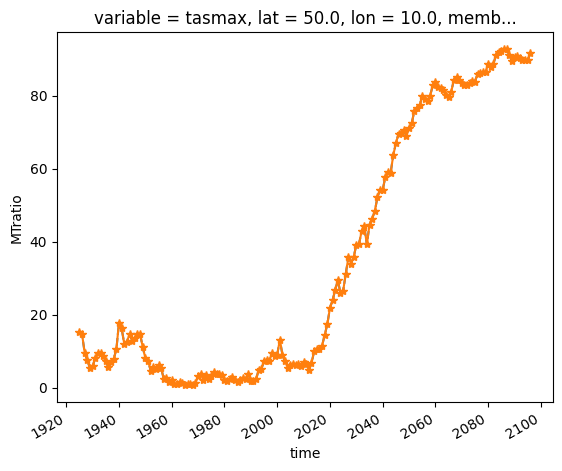

In [31]:
# for i in range(len(test_return.concat_dim)):
test_return.isel(variable=0, region=0, concat_dim=0).MTratio.plot(linestyle='dashed')
test_return.isel(variable=0, region=0, concat_dim=1).MTratio.plot(marker='*')

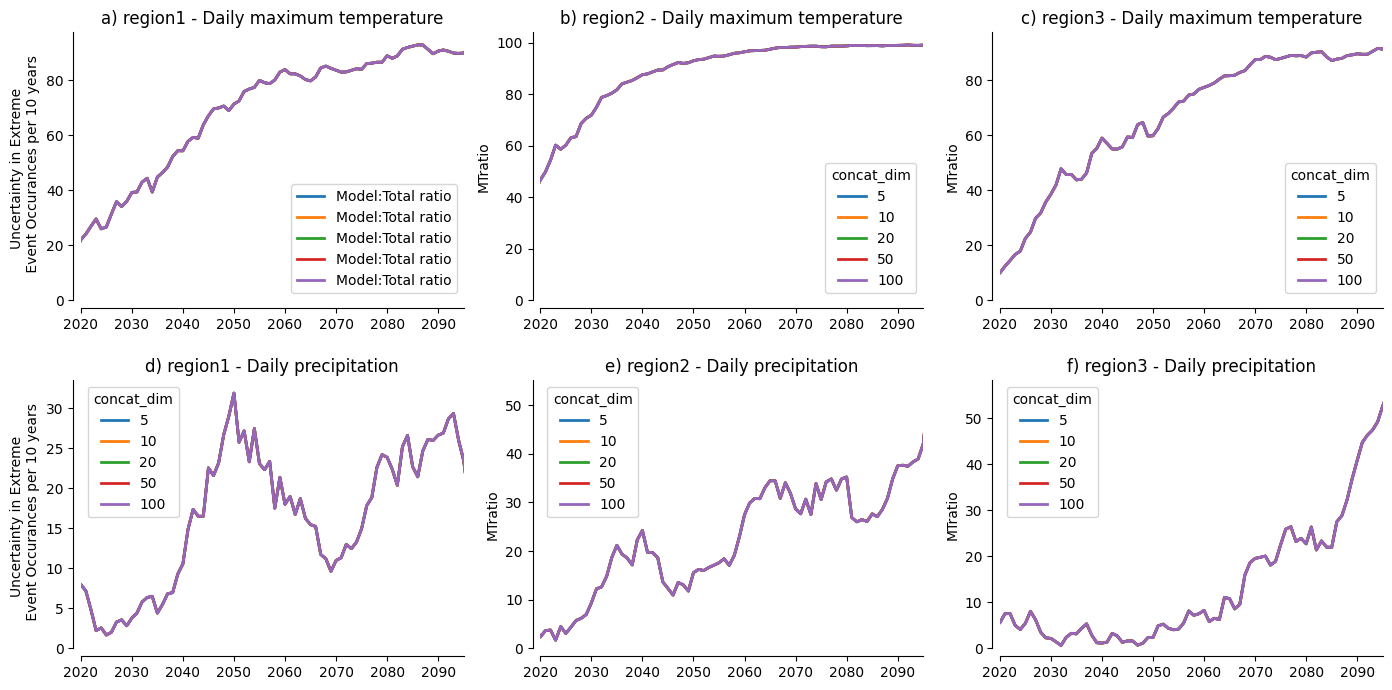

In [50]:
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_return['variable'].values):
    for ir, r in enumerate(test_return.region.values):
        ax = axs[iv, ir]
        # for im, m in enumerate(internal.model.values):
        test_return.sel(variable=v, region=r).MTratio.plot(hue='concat_dim',ax=ax, lw=2,label='Model:Total ratio')
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Uncertainty in Extreme \n Event Occurances per 10 years')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# fig.savefig('./plots/std_uncertainties_noscenario.png', dpi=200)

## Sensitivity plots for paper

#### Get Data 

In [32]:
# setting 
# variable = 'tas'
# variable = 'tasmax'
# variable = 'pr'
models = ['MIROC6', 'CanESM5', 'MPI-ESM1-2-LR', 'EC-Earth3','cesm_lens']

In [33]:
# USwest = MultiModelLargeEnsemble(models=models, variable=variable, granularity='day', 
#                                lat=37.7, lon=237.6, 
#                                bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [49]:
europe_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=51, lon=10.5, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [50]:
australia_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=-25.2, lon=133.7, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [51]:
tropics_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=3.9, lon=306.9, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [52]:
europe_tas = MultiModelLargeEnsemble(models=models, variable='tas', granularity='day', 
                               lat=51, lon=10.5, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [53]:
australia_tas = MultiModelLargeEnsemble(models=models, variable='tas', granularity='day', 
                               lat=-25.2, lon=133.7, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [54]:
tropics_tas = MultiModelLargeEnsemble(models=models, variable='tas', granularity='day', 
                               lat=3.9, lon=306.9, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

#### Test_return

In [57]:
test_return_pr = sensitivity_allregions(parameter='return_period',
                                     regions=[europe_pr,australia_pr,tropics_pr],
                 x_type='quantile_return',
                 load=False,
                 args = {'return_period':[5,10,20,50,100],
                            'coarsen':1,
                            'consec_days':1,
                            'rolling_average':10,
                            'hist_slice':slice('1995','2014')
                            })

100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


43.337318420410156


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


43.33949661254883


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


43.34236526489258


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


43.33695602416992


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


43.33293151855469


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.33869171142578


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


43.34035873413086


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


43.33266830444336


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


43.337196350097656


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


43.33697509765625


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


43.339542388916016


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


43.3432731628418


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


43.33879470825195


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


43.33734130859375


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


43.34539794921875


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


43.335533142089844


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


43.33708953857422


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


43.339683532714844


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


43.335453033447266


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


43.39695739746094


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.383445739746094


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.39432907104492


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


43.3897819519043


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


43.39619064331055


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


43.391197204589844


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


43.40049743652344


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


43.401676177978516


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


43.397422790527344


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


43.39697265625


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


43.397438049316406


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.40253829956055


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.39885330200195


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


43.4040412902832


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


43.39960861206055


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


43.39958572387695


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.3967399597168


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


43.396846771240234


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


43.40168380737305


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


43.399715423583984


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


43.39609146118164


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.39706802368164


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.40497970581055


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


43.402103424072266


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


43.403717041015625


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


43.39759063720703


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


43.40345764160156


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


43.40167999267578


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


43.40526580810547


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


43.407325744628906


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


43.396907806396484


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


43.40091323852539


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


43.4031867980957


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


43.3974494934082


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


43.40024185180664


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


43.40360641479492


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


43.402950286865234


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.40610885620117


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


43.40042495727539


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.39725112915039


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


43.399967193603516


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


43.40396499633789


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.40340042114258


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


43.40488052368164


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


43.40230178833008


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


43.400634765625


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


43.40387725830078


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


43.40385055541992


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


43.40605926513672


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


43.3974609375


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


43.39891815185547


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.406028747558594


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.405914306640625


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


43.40056610107422


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


43.39607238769531


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

43.399208068847656


In [ ]:
test_return_tas = sensitivity_allregions(parameter='return_period',
                                     regions=[europe_tas,australia_tas,tropics_tas],
                 x_type='quantile_return',
                 load=False,
                 args = {'return_period':[5,10,20,50,100],
                            'coarsen':1,
                            'consec_days':1,
                            'rolling_average':10,
                            'hist_slice':slice('1995','2014')
                            })

In [71]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_return = xr.concat([test_return_tas,test_return_pr], dim=variable_dim)

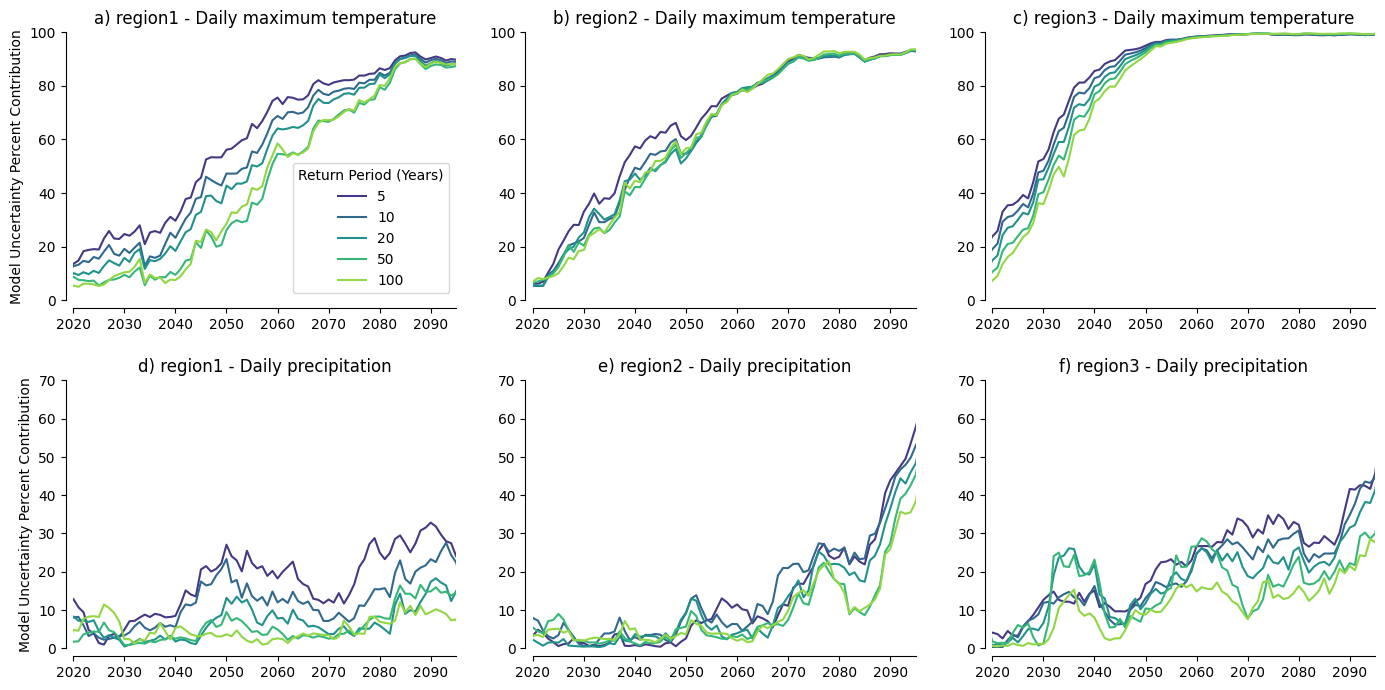

In [126]:
colors = sns.color_palette("viridis", len(test_return.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_return['variable'].values):
    for ir, r in enumerate(test_return.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_return.concat_dim.values):
            ax.plot(test_return.sel(variable=v,region=r,concat_dim=m).time,test_return.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['5','10','20','50','100']
axs[0, 0].legend(labels=labels,title='Return Period (Years)')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
for ax in axs[0,:]:
    ax.set_ylim(bottom=0,top=100)
for ax in axs[1,:]:
    ax.set_ylim(bottom=0,top=70)
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testreturn.png', dpi=200)

#### Hist slice

In [93]:
test_histslice_pr = sensitivity_allregions(parameter='hist_slice',
                                        regions=[europe_pr,australia_pr,tropics_pr],
                                        x_type = 'quantile_return',
                                        load=False,
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'consec_days':1,
                                                'rolling_average':10,
                                                'hist_slice':[slice('1980','2000'),
                                                              slice('1990','2010'),slice('1995','2014'),
                                                              slice(None, None), slice('1990', None)]
                                               }
                                       )

100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


43.495567321777344


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


43.499839782714844


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


43.494895935058594


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


43.49604797363281


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


43.49299621582031


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


43.499534606933594


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.496055603027344


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


43.48876190185547


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


43.496498107910156


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


43.4984130859375


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


43.497711181640625


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.49108123779297


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


43.48831558227539


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.490882873535156


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


43.490867614746094


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


43.506771087646484


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


43.500240325927734


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


43.502193450927734


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.498050689697266


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


43.49942398071289


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


43.50468063354492


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.50578689575195


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


43.50534439086914


100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


43.50114059448242


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


43.5012092590332


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.507625579833984


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


43.50717544555664


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


43.5085334777832


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


43.50553512573242


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


43.503292083740234


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.50957107543945


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.50802230834961


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


43.51580810546875


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


43.507232666015625


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


43.50659942626953


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


43.50447082519531


100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


43.486602783203125


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


43.490447998046875


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.49354553222656


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


43.49663543701172


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.49140167236328


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


43.49591827392578


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


43.49089050292969


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


43.48646926879883


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


43.4940299987793


100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


43.49288558959961


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.49153518676758


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


43.4868278503418


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.498291015625


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


43.489845275878906


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


43.48564910888672


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


43.492889404296875


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


43.486656188964844


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


43.4886474609375


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


43.48809814453125


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.492591857910156


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.48925018310547


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


43.49895477294922


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


43.485870361328125


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


43.4912109375


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


43.48916244506836


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


43.48597717285156


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


43.48873519897461


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


43.49506378173828


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


43.49443054199219


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


43.49371337890625


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.49542999267578


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


43.498008728027344


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


43.495384216308594


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


43.494873046875


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


43.49029541015625


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.5010986328125


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


43.494140625


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


43.49419403076172


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

43.49623107910156


In [94]:
test_histslice_tas = sensitivity_allregions(parameter='hist_slice',
                                        regions=[europe_tas,australia_tas,tropics_tas],
                                        x_type = 'quantile_return',
                                        load=False,
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'consec_days':1,
                                                'rolling_average':10,
                                                'hist_slice':[slice('1980','2000'),
                                                              slice('1990','2010'),slice('1995','2014'),
                                                              slice(None, None), slice('1990', None)]
                                               }
                                       )

100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.487613677978516


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


43.492008209228516


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


43.49648666381836


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


43.4976806640625


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


43.49931335449219


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


43.49424743652344


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.493980407714844


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


43.498870849609375


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.48797607421875


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


43.493011474609375


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


43.490386962890625


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.49718475341797


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


43.488059997558594


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.49236297607422


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


43.49052429199219


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.495689392089844


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.498252868652344


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


43.489295959472656


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


43.494422912597656


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


43.49809265136719


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


43.48759460449219


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


43.48970413208008


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


43.49335479736328


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.497310638427734


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


43.49204635620117


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.48992156982422


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.490318298339844


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


43.489776611328125


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


43.49394226074219


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


43.489227294921875


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.493011474609375


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


43.49131774902344


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


43.49070739746094


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


43.48875427246094


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


43.49186706542969


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


43.489437103271484


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


43.49137496948242


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


43.49692916870117


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.485252380371094


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


43.49052810668945


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.49135208129883


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


43.493831634521484


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


43.49325180053711


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.49077224731445


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


43.49051284790039


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.4970817565918


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


43.4931526184082


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


43.4910774230957


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


43.49101638793945


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


43.487491607666016


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


43.48861312866211


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.49637222290039


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


43.48923873901367


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.49325180053711


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


43.48691177368164


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


43.487789154052734


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.500701904296875


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


43.49015426635742


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


43.4957389831543


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


43.49274826049805


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


43.49241256713867


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.487613677978516


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


43.494991302490234


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.4929313659668


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


43.49374771118164


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.49514389038086


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.489749908447266


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


43.49013137817383


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.495723724365234


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


43.49361038208008


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


43.49717330932617


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


43.496891021728516


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


43.49795150756836


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


43.49160385131836


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

43.49677276611328


In [95]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_histslice = xr.concat([test_histslice_tas,test_histslice_pr], dim=variable_dim)

In [97]:
test_histslice

<xarray.Dataset>
Dimensions:     (variable: 2, time: 106, region: 3, concat_dim: 5, model: 5)
Coordinates:
  * variable    (variable) <U6 'tasmax' 'pr'
  * time        (time) datetime64[ns] 1995-01-01 1996-01-01 ... 2100-01-01
    lat         (region) float64 50.0 -25.0 5.0
    lon         (region) float64 10.0 132.5 307.5
  * model       (model) <U13 'MIROC6' 'CanESM5' ... 'EC-Earth3' 'cesm_lens'
    quantile    (model) float64 0.9995 0.9995 0.9995 0.9995 0.9995
    q_values    (variable, region, model) float64 301.7 298.2 ... 0.0003968
    member_id   int64 1
  * concat_dim  (concat_dim) object slice('1980', '2000', None) ... slice('19...
  * region      (region) <U7 'region1' 'region2' 'region3'
Data variables:
    M_LE        (variable, region, concat_dim, time) float64 0.08736 ... nan
    I_LE        (variable, region, concat_dim, model, time) float64 4.002 ......
    Ibar_LE     (variable, region, concat_dim, time) float64 4.941 4.962 ... nan
    T_LE        (variable, region, concat_dim, time) float64 3.216 3.198 ... nan
    FIT         (variable, region, concat_dim, time, model) float64 2.544 ......
    M_FIT       (variable, region, concat_dim, time) float64 24.63 ... 4.248
    I_FIT       (variable, region, concat_dim, model) float64 171.1 ... 0.842
    Ibar_FIT    (variable, region, concat_dim) float64 283.5 181.0 ... 0.6926
    T_FIT       (variable, region, concat_dim, time) float64 3.216 3.198 ... nan
    MTratio     (variable, region, concat_dim, time) float64 1.737 1.582 ... nan

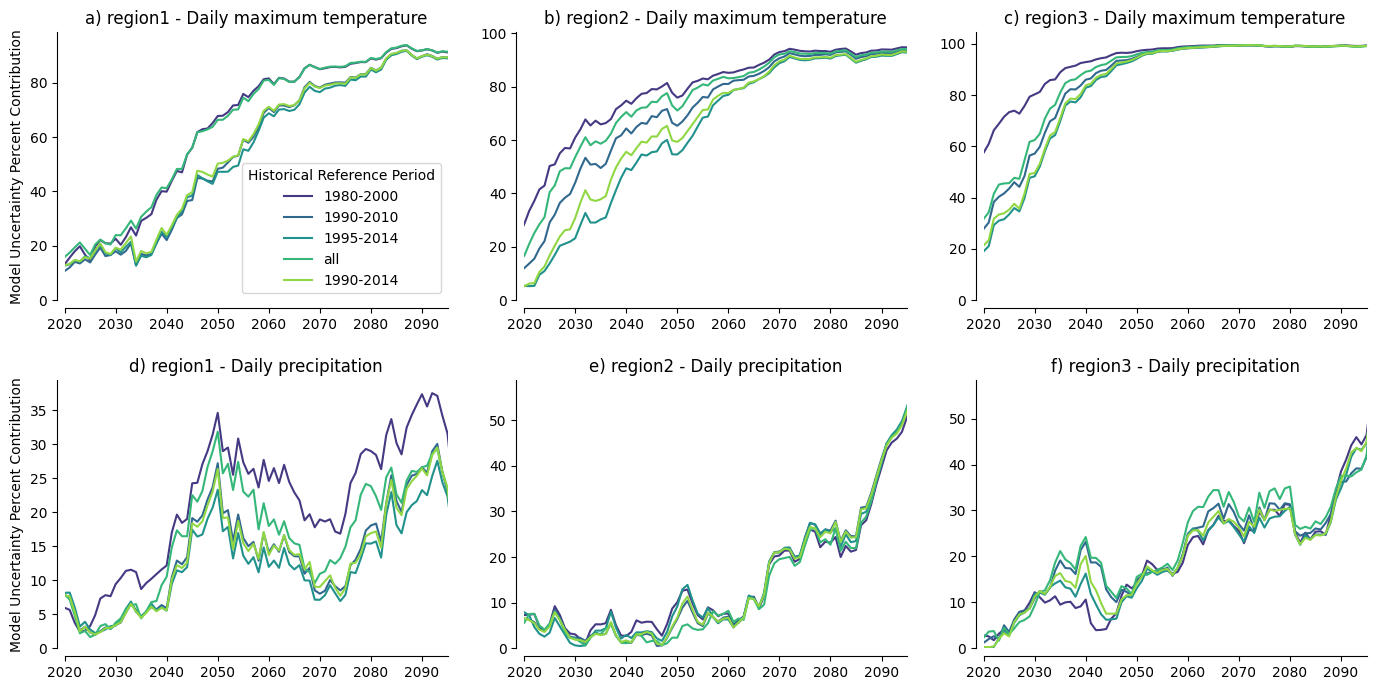

In [102]:
colors = sns.color_palette("viridis", len(test_histslice.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_histslice['variable'].values):
    for ir, r in enumerate(test_histslice.region.values):
        ax = axs[iv, ir]
        for im in range(len(test_histslice.concat_dim.values)):
            ax.plot(test_histslice.sel(variable=v,region=r).isel(concat_dim=im).time,test_histslice.sel(variable=v,region=r).isel(concat_dim=im).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels = ['1980-2000','1990-2010','1995-2014','all','1990-2014']
axs[0, 0].legend(labels=labels,title='Historical Reference Period')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testhistslice.png', dpi=200)

#### Test coarsen

In [104]:
test_coarsen_tas = sensitivity_allregions(parameter='coarsen',
                                          regions=[europe_tas,australia_tas,tropics_tas],
                                    x_type = 'quantile_return',
                                    load=False,
                                    args = {'return_period':10,
                                            'coarsen':[1,3,5,7],
                                            'consec_days':1,
                                            'rolling_average':10,
                                            'hist_slice':slice('1995','2014')
                                            
                                           })

100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.48945236206055


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


43.494136810302734


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


43.4863166809082


100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


43.4893684387207


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


43.4913444519043


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.515377044677734


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


43.51402282714844


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


43.497657775878906


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.67246627807617


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


43.48942947387695


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


43.49452590942383


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


43.48982620239258


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


43.489322662353516


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.487728118896484


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


43.49233627319336


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


43.4846305847168


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.49214553833008


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


43.484649658203125


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.47445297241211


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


43.4815559387207


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


43.47579574584961


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


43.4814453125


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


43.47833251953125


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.47498321533203


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


43.471641540527344


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.47296142578125


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.4821891784668


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


43.480224609375


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


43.474334716796875


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


43.47517395019531


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


43.47441864013672


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


43.48094940185547


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


43.47827911376953


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


43.47428894042969


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


43.47801971435547


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.47532653808594


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.470726013183594


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


43.477210998535156


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


43.476776123046875


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


43.477256774902344


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


43.47114562988281


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.475589752197266


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


43.4754524230957


100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


43.47715377807617


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


43.47804260253906


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


43.47771453857422


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.472755432128906


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


43.47405242919922


100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


43.472991943359375


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


43.472862243652344


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.478187561035156


100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


43.4702033996582


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


43.47929763793945


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


43.47358322143555


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


43.47947311401367


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.47783279418945


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


43.47151565551758


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


43.4799919128418


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


43.47818374633789


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

43.4788932800293


In [108]:
test_coarsen_pr = sensitivity_allregions(parameter='coarsen',
                                          regions=[europe_pr,australia_pr,tropics_pr],
                                    x_type = 'quantile_return',
                                    load=False,
                                    args = {'return_period':10,
                                            'coarsen':[1,3,5,7],
                                            'consec_days':1,
                                            'rolling_average':10,
                                            'hist_slice':slice('1995','2014')
                                            
                                           })


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.49699401855469



100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


43.4921875



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


43.492652893066406



100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


43.49581527709961



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


43.497554779052734



100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


43.49294662475586



100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


43.492042541503906



100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


43.48799133300781



100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


43.49089813232422



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.48799133300781



100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


43.489418029785156



100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


43.49620056152344



100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


43.49711608886719



100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


43.487770080566406



100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


43.49171447753906



100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


43.489707946777344



100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.492374420166016



100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


43.49335861206055



100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


43.48953628540039



100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


43.48982620239258



100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.49262619018555



100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


43.492916107177734



100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


43.489376068115234



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.491172790527344



100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


43.485862731933594



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


43.49227523803711



100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


43.4914436340332



100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


43.494686126708984



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.4858512878418



100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


43.48512649536133



100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


43.49197769165039



100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


43.49284744262695



100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


43.48948287963867



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.48604202270508



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


43.4956169128418



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.49393844604492



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.49228286743164



100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


43.48988723754883



100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.49502182006836



100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


43.49295425415039



100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


43.496971130371094



100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


43.4915771484375



100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


43.490020751953125



100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


43.49085998535156



100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


43.486114501953125



100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


43.488037109375



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.49095153808594



100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


43.49767303466797



100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


43.48638153076172



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


43.487403869628906



100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


43.49394989013672



100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


43.4920654296875



100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


43.489356994628906



100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


43.48661804199219



100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


43.493446350097656



100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.49193572998047



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.48760223388672



100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


43.48539733886719



100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.49247741699219



100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

43.494773864746094


In [109]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_coarsen = xr.concat([test_coarsen_tas,test_coarsen_pr], dim=variable_dim)

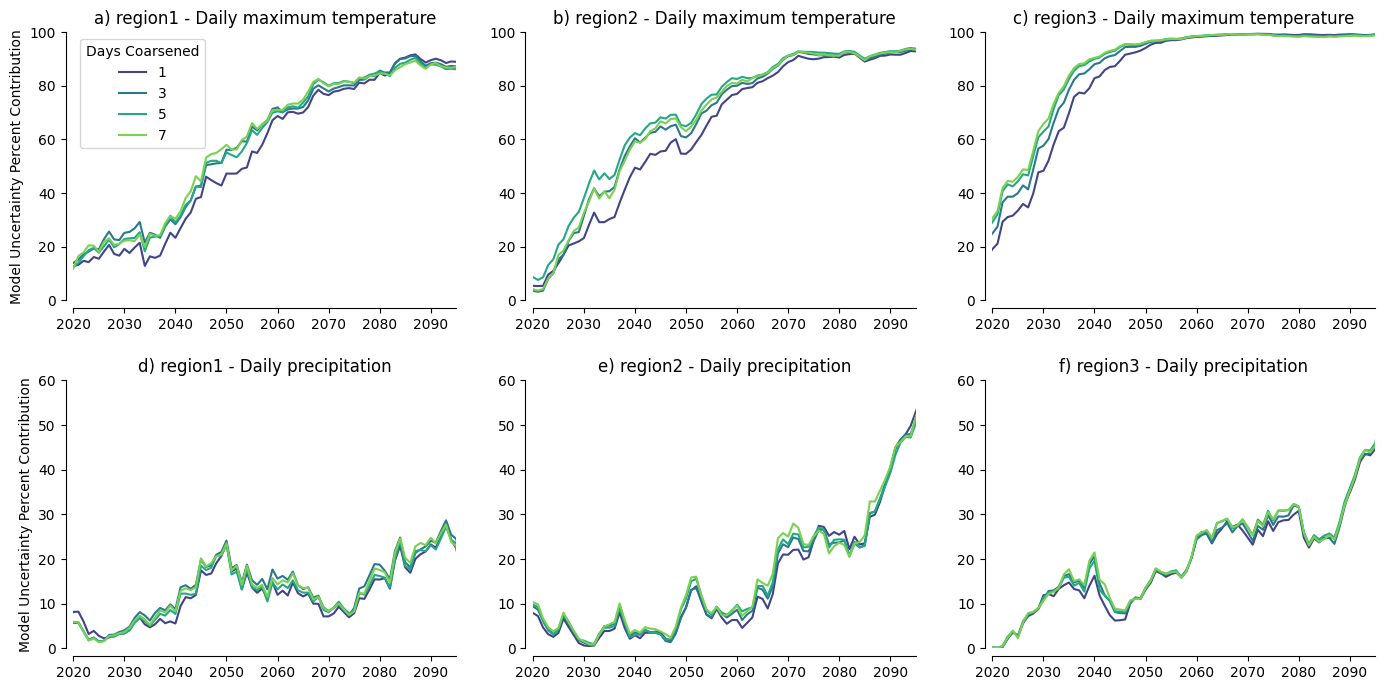

In [127]:
colors = sns.color_palette("viridis", len(test_coarsen.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_coarsen['variable'].values):
    for ir, r in enumerate(test_coarsen.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_coarsen.concat_dim.values):
            ax.plot(test_coarsen.sel(variable=v,region=r,concat_dim=m).time,test_coarsen.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['1','3','5','7']
axs[0, 0].legend(labels=labels,title='Days Coarsened')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
for ax in axs[0,:]:
    ax.set_ylim(bottom=0,top=100)
for ax in axs[1,:]:
    ax.set_ylim(bottom=0,top=60)
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testcoarsen.png', dpi=200)

#### Test consecutive days

In [112]:
test_consec_tas = sensitivity_allregions(parameter='consec_days',
                                         regions=[europe_tas,australia_tas,tropics_tas],
                                     x_type='quantile_return',
                                     load=False,
                       args= {'return_period':10,
                              'coarsen':7,
                              'consec_days':[1,3,5,7],
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014')
                             }
                      )


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


43.493690490722656



100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.488853454589844



100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


43.490509033203125



100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


43.49475860595703



  0%|          | 0/1 [05:22<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

43.48899841308594



100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


43.49066925048828


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


43.48862075805664


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


43.488094329833984


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


43.489131927490234


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

43.48940658569336



100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


43.49611282348633


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


43.49495315551758


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


43.488407135009766


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


43.49143981933594


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

43.48985290527344



100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


43.48907470703125


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


43.491432189941406


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


43.492881774902344


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


43.495018005371094


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


43.49842071533203


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


43.49519348144531


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


43.49278259277344


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


43.49305725097656


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.48799514770508


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

43.4941520690918



100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


43.49382400512695


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


43.50065994262695


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


43.492679595947266


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


43.500465393066406


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

43.49311065673828



100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


43.492889404296875


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


43.48969268798828


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


43.48931121826172


100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


43.487037658691406


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

43.48833465576172



100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


43.49297332763672


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


43.498085021972656


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


43.49768829345703


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


43.49565505981445


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


43.49381637573242


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


43.4920539855957


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


43.4959602355957


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


43.48910903930664


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


43.49680709838867


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

43.496246337890625



100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


43.49191665649414


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


43.494937896728516


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


43.48871994018555


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


43.49447250366211


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

43.48637008666992



100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


43.48659896850586


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


43.49037551879883


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


43.498348236083984


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


43.50822830200195


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

43.53245162963867



100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


43.64886474609375


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


43.48670959472656


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

43.49681854248047



100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


43.494178771972656


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

43.49537658691406


In [113]:
test_consec_pr = sensitivity_allregions(parameter='consec_days',
                                         regions=[europe_pr,australia_pr,tropics_pr],
                                     x_type='quantile_return',
                                     load=False,
                       args= {'return_period':10,
                              'coarsen':7,
                              'consec_days':[1,3,5,7],
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014')
                             }
                      )

100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


43.490684509277344


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


43.48839569091797


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


43.489707946777344


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


43.49324035644531


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

43.495018005371094



100%|██████████| 1/1 [00:02<00:00,  2.52s/it]

43.490379333496094



100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


43.49104309082031


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


43.486297607421875


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


43.49290084838867


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

43.49581527709961



100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


43.494632720947266


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


43.48692321777344


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


43.49052429199219


100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


43.48548889160156


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

43.491058349609375



100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


43.487693786621094


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


43.49745178222656


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


43.49104309082031


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


43.48435974121094


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


43.491310119628906


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.493896484375


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


43.489295959472656


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


43.4904899597168


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.489688873291016


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

43.492549896240234



100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


43.49048614501953


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


43.49079132080078


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


43.488014221191406


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


43.48778533935547


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

43.492149353027344



100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


43.49462127685547


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


43.493080139160156


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


43.489585876464844


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


43.4921875


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

43.488258361816406



100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

43.49507141113281



100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


43.491703033447266


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


43.4955940246582


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


43.49522018432617


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


43.49848556518555


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


43.492916107177734


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.48650360107422


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


43.497344970703125


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


43.49061584472656


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

43.49836730957031



100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


43.486175537109375


100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


43.48699951171875


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


43.48845672607422


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


43.48918151855469


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

43.49360656738281



100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


43.4876823425293


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


43.49251937866211


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


43.4875373840332


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


43.49592590332031


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

43.49095916748047



100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


43.493804931640625


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


43.49367141723633


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


43.4885368347168


100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


43.48770523071289


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

43.4854850769043


In [114]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_consec = xr.concat([test_consec_tas,test_consec_pr], dim=variable_dim)

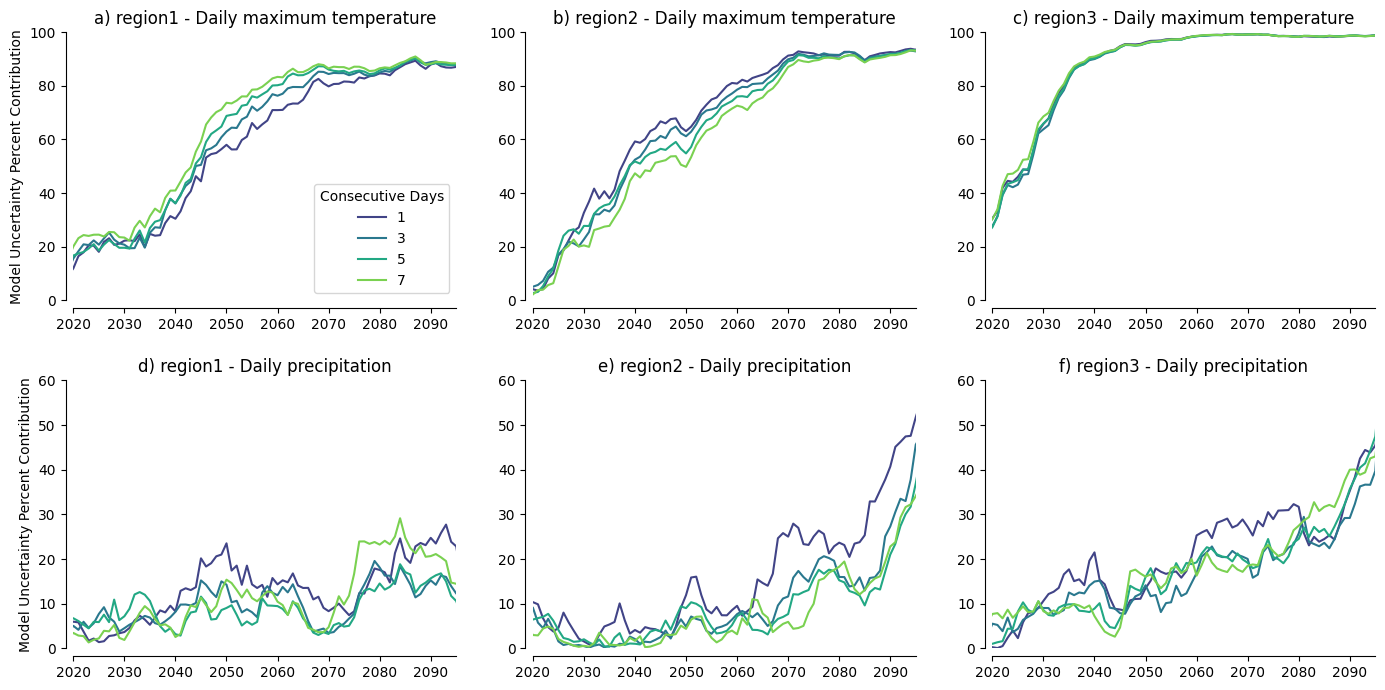

In [129]:
colors = sns.color_palette("viridis", len(test_consec.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_consec['variable'].values):
    for ir, r in enumerate(test_consec.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_consec.concat_dim.values):
            ax.plot(test_consec.sel(variable=v,region=r,concat_dim=m).time,test_consec.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['1','3','5','7']
axs[0, 0].legend(labels=labels,title='Consecutive Days')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')

for ax in axs[0,:]:
    ax.set_ylim(bottom=0,top=100)
for ax in axs[1,:]:
    ax.set_ylim(bottom=0,top=60)
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testconsec.png', dpi=200)

#### test rolling average

In [117]:
test_rolling_tas = sensitivity_allregions(parameter='rolling_average',
                                          regions=[europe_tas,australia_tas,tropics_tas],
                                       x_type='quantile_return',
                                     load=False,
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'consec_days':1,
                                                'rolling_average':[1,5,10,15,20],
                                                'hist_slice':slice('1995','2014')
                                               }
                                     )

100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


43.49214172363281


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


43.49319076538086


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


43.4907112121582


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.48903274536133


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


43.4916877746582


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


43.49586868286133


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


43.49374008178711


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


43.49031448364258


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.49733352661133


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


43.49100112915039


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


43.489463806152344


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


43.49217224121094


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


43.49864959716797


100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


43.49432373046875


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


43.493408203125


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.49302673339844


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.49365234375


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


43.498313903808594


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.492496490478516


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


43.50141906738281


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.49694061279297


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


43.494873046875


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


43.494659423828125


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


43.492462158203125


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


43.498985290527344


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.49481964111328


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


43.49188995361328


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


43.496856689453125


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.48955535888672


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


43.486202239990234


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


43.49551773071289


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


43.489784240722656


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


43.49391174316406


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.494163513183594


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


43.49818420410156


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


43.49517822265625


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.4918327331543


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


43.495784759521484


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.49403762817383


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


43.48777389526367


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.49642562866211


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.4941291809082


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


43.500667572021484


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.49342727661133


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


43.49643325805664


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.490596771240234


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.49386215209961


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


43.49037551879883


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.495113372802734


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


43.49528884887695


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


43.49214553833008


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


43.49093246459961


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


43.49648666381836


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.49643325805664


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


43.48702621459961


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.49687194824219


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


43.49668884277344


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


43.49658966064453


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.493011474609375


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


43.49420928955078


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


43.49420928955078


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


43.49452209472656


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


43.49603271484375


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


43.486900329589844


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


43.494712829589844


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.494869232177734


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


43.4910774230957


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


43.49140548706055


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


43.498355865478516


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


43.49984359741211


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.491641998291016


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


43.4965705871582


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


43.48842239379883


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


43.48847198486328


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

43.49480438232422


In [118]:
test_rolling_pr = sensitivity_allregions(parameter='rolling_average',
                                          regions=[europe_pr,australia_pr,tropics_pr],
                                       x_type='quantile_return',
                                     load=False,
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'consec_days':1,
                                                'rolling_average':[1,5,10,15,20],
                                                'hist_slice':slice('1995','2014')
                                               }
                                     )

100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.49402618408203


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


43.49577331542969


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


43.48857879638672


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


43.49677276611328


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


43.49396514892578


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.491390228271484


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.49531173706055


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


43.48994064331055


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


43.48995590209961


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


43.495365142822266


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


43.49293899536133


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.4998893737793


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


43.49319839477539


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


43.49393081665039


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


43.49195861816406


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.489532470703125


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.48805236816406


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


43.48957824707031


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


43.48771667480469


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


43.48516845703125


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


43.49066925048828


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


43.4966926574707


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


43.490665435791016


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


43.49647903442383


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


43.491493225097656


100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


43.49569320678711


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.494422912597656


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


43.491249084472656


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.493927001953125


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


43.498138427734375


100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


43.493106842041016


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


43.48917770385742


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


43.498661041259766


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.495540618896484


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


43.49614334106445


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


43.49203109741211


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


43.49147415161133


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


43.49386215209961


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.49582290649414


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


43.49150466918945


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.49128341674805


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.49335861206055


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


43.49497604370117


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


43.49252700805664


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


43.49898910522461


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.49294662475586


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.494632720947266


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


43.49030685424805


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


43.493377685546875


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


43.49033737182617


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


43.48454666137695


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


43.488643646240234


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


43.49042892456055


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.492679595947266


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


43.48947525024414


100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


43.49098587036133


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.4899787902832


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


43.4854850769043


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


43.49116134643555


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


43.489505767822266


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


43.4896125793457


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.4908332824707


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


43.494014739990234


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.493045806884766


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


43.49575424194336


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


43.49697494506836


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.49164962768555


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


43.495113372802734


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


43.49061965942383


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


43.49455642700195


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


43.49428939819336


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.49433517456055


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


43.4888801574707


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


43.49616241455078


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

43.48889923095703


In [119]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_rolling = xr.concat([test_rolling_tas,test_rolling_pr], dim=variable_dim)

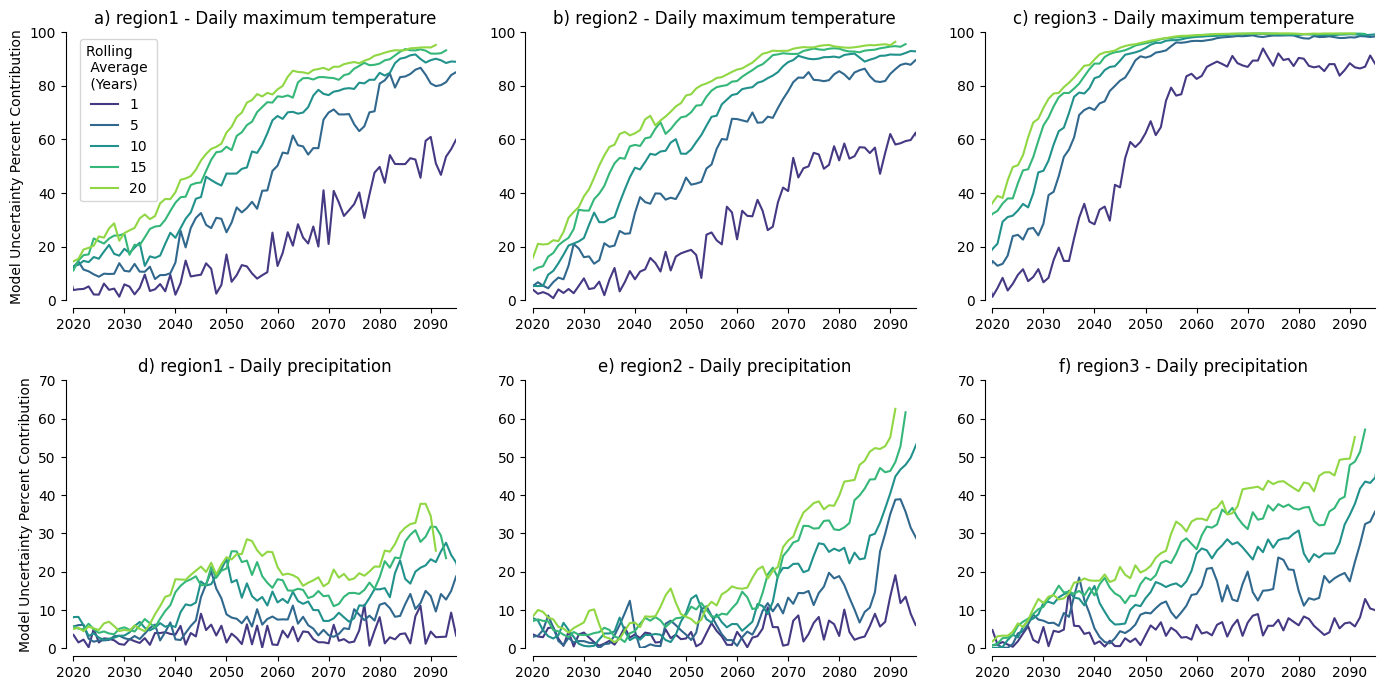

In [131]:
colors = sns.color_palette("viridis", len(test_rolling.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_rolling['variable'].values):
    for ir, r in enumerate(test_rolling.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_rolling.concat_dim.values):
            ax.plot(test_rolling.sel(variable=v,region=r,concat_dim=m).time,test_rolling.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['1','5','10','15','20']
axs[0, 0].legend(labels=labels,title='Rolling \n Average \n (Years)')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
for ax in axs[0,:]:
    ax.set_ylim(bottom=0,top=100)
for ax in axs[1,:]:
    ax.set_ylim(bottom=0,top=70)
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testrolling.png', dpi=200)

### Tas vs Tasmax

In [132]:
# load global data 
tasmax_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [136]:
tasmax_mmle.compute_x(x_type='quantile_return', load=True, name='tasmax_default_quantile_return_10yr')

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/EC-Earth3.zarr


In [137]:
tasmax_mmle.x.load()
tasmax_mmle.compute_LE()
tasmax_mmle.compute_FIT()
internal_tasmax = tasmax_mmle.results
tasmax = tasmax_mmle.x

In [133]:
# load global data 
tas_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tas', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [138]:
tas_mmle.compute_x(x_type='quantile_return', load=True, name='tas_default_quantile_return_10yr')

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr/EC-Earth3.zarr


In [139]:
tas_mmle.x.load()
tas_mmle.compute_LE()
tas_mmle.compute_FIT()
internal_tas = tas_mmle.results
tas = tas_mmle.x

In [140]:
regions = ['region1', 'region2', 'region3']
lats = [51, 3.9, -25.2]
lons = [10.5, 306.9, 133.7]
region_dim = xr.DataArray(regions, coords={'region': regions})

In [141]:
x = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
).drop('q_values') for ds in [tas, tasmax]])

In [142]:
x = x.to_array()

In [143]:
variable_dim = xr.DataArray(['tas', 'tasmax'], coords={'variable': ['tas', 'tasmax']}, name='variable')

In [144]:
internal = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tas, internal_tasmax]], dim=variable_dim)

In [146]:
internal['MTratio'] = (internal.M_LE/(internal.M_LE+internal.Ibar_LE))*100

In [148]:
internal

<xarray.Dataset>
Dimensions:    (variable: 2, time: 181, region: 3, model: 5)
Coordinates:
  * variable   (variable) <U6 'tas' 'tasmax'
  * time       (time) datetime64[ns] 1920-01-01 1921-01-01 ... 2100-01-01
    lat        (region) float64 50.0 5.0 -25.0
    lon        (region) float64 10.0 307.5 132.5
  * model      (model) <U13 'MIROC6' 'cesm_lens' ... 'MPI-ESM1-2-LR' 'EC-Earth3'
    q_values   (variable, model, region) float64 301.8 303.7 ... 305.2 318.5
    quantile   (model) float64 0.9997 0.9997 0.9997 0.9997 0.9997
    member_id  int64 1
  * region     (region) <U7 'region1' 'region2' 'region3'
Data variables:
    M_LE       (variable, time, region) float64 nan nan nan nan ... nan nan nan
    I_LE       (variable, model, time, region) float64 nan nan nan ... nan nan
    Ibar_LE    (variable, time, region) float64 nan nan nan nan ... nan nan nan
    T_LE       (variable, time, region) float64 nan nan nan nan ... nan nan nan
    FIT        (variable, time, model, region) float64 19.86 45.53 ... 285.5
    M_FIT      (variable, time, region) float64 8.485e+03 ... 2.438e+04
    I_FIT      (variable, model, region) float64 85.57 4.21e+03 ... 511.9
    Ibar_FIT   (variable, region) float64 158.4 2.967e+04 ... 8.876e+03 162.2
    T_FIT      (variable, time, region) float64 nan nan nan nan ... nan nan nan
    MTratio    (variable, time, region) float64 nan nan nan nan ... nan nan nan

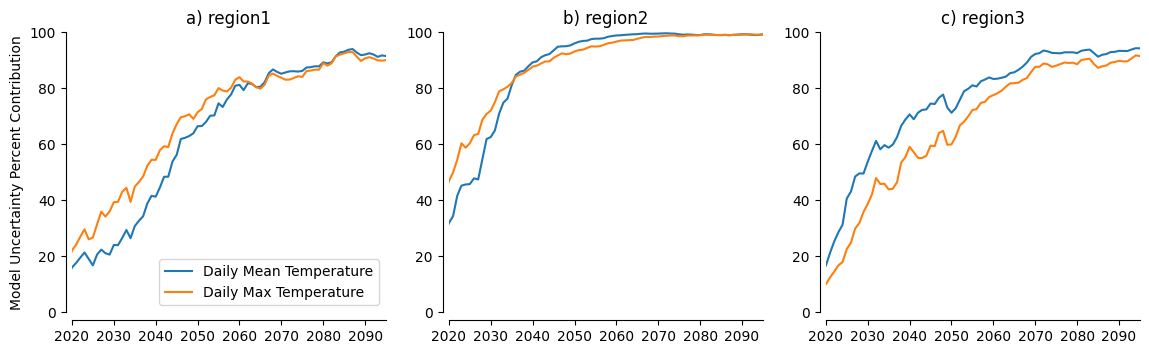

In [219]:
colors = sns.color_palette("viridis", len(test_rolling.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=1,ncols=3, constrained_layout=True,figsize=(12,4))

axes = [axs[0],axs[1],axs[2]]
regions = ['region1','region2','region3']
count=0
for ax,r in zip(axes,regions):
    ax.plot(internal.sel(variable='tas',region=r).time,internal.sel(variable='tas',region=r).MTratio,label='Daily Mean Temperature')
    ax.plot(internal.sel(variable='tasmax',region=r).time,internal.sel(variable='tasmax',region=r).MTratio,label='Daily Max Temperature')
    
    ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
    ax.set_ylim(bottom=0,top=100)
    ax.set_title(f'{string.ascii_lowercase[count]}) {r}')
    ax.set_xlabel('')
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines["bottom"].set_position(("axes", -0.03)) 
    ax.spines["left"].set_position(("axes", -0.02))
    count += 1
axs[0].legend()
axs[0].set_ylabel('Model Uncertainty Percent Contribution')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.2, top=0.9, wspace=0.20, hspace=0.70)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_tastasmax.png', dpi=200)

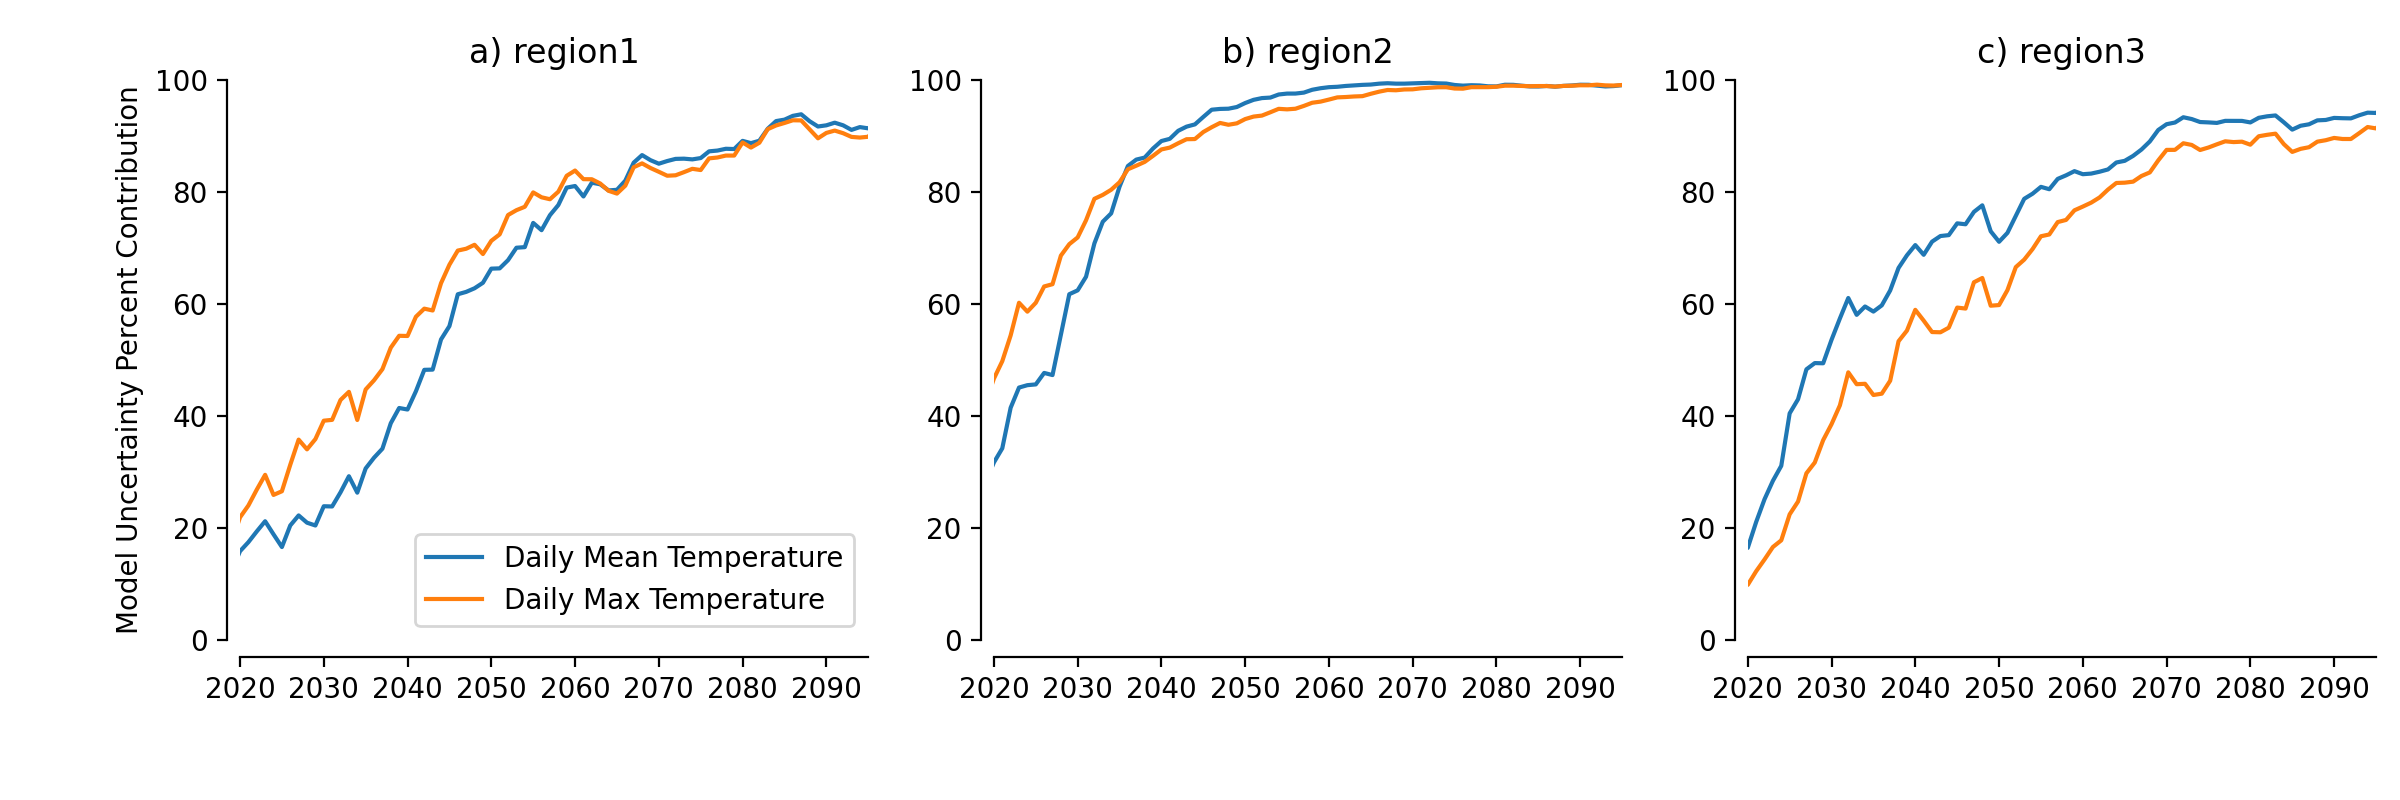

In [220]:
from IPython.display import Image
Image(filename='./plots/sensitivity_tastasmax.png')   # Don't believe what Jupyter shows you!

## Default vs TXx returns vx TXx

### Default

In [221]:
# load global data 
tasmax_default = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

tasmax_default.compute_x(x_type='quantile_return', load=True, name='tasmax_default_quantile_return_10yr')

tasmax_default.x.load()
tasmax_default.compute_LE()
tasmax_default.compute_FIT()
internal_tasmax_default = tasmax_default.results
tasmax_default = tasmax_default.x

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr/EC-Earth3.zarr


In [222]:
# load global data 
pr_default = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

pr_default.compute_x(x_type='quantile_return', load=True, name='pr_default_quantile_return_10yr')

pr_default.x.load()
pr_default.compute_LE()
pr_default.compute_FIT()
internal_pr_default = pr_default.results
pr_default = pr_default.x

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/EC-Earth3.zarr


In [223]:
regions = ['region1', 'region2', 'region3']
lats = [51, 3.9, -25.2]
lons = [10.5, 306.9, 133.7]
region_dim = xr.DataArray(regions, coords={'region': regions})

x_default = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
).drop('q_values') for ds in [tasmax_default, pr_default]])

x_default = x_default.to_array()

variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

internal_default = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tasmax_default, internal_pr_default]], dim=variable_dim)

internal_default['MTratio'] = (internal_default.M_LE/(internal_default.M_LE+internal_default.Ibar_LE))*100

### TXx Return

In [224]:
# load global data 
tasmax_TXx_return = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

tasmax_TXx_return.compute_x(x_type='TXx_quantile', load=True, name='tasmax_TXx_quantile_return_10yr')

tasmax_TXx_return.x.load()
tasmax_TXx_return.compute_LE()
tasmax_TXx_return.compute_FIT()
internal_tasmax_TXx_return = tasmax_TXx_return.results
tasmax_TXx_return = tasmax_TXx_return.x

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_TXx_quantile_return_10yr/MIROC6.zarr


KeyError: '.zmetadata'

In [ ]:
# load global data 
pr_TXx_return = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

pr_TXx_return.compute_x(x_type='TXx_quantile', load=True, name='pr_TXx_quantile_return_10yr')

pr_TXx_return.x.load()
pr_TXx_return.compute_LE()
pr_TXx_return.compute_FIT()
internal_pr_TXx_return = pr_TXx_return.results
pr_TXx_return = pr_TXx_return.x

In [ ]:
regions = ['region1', 'region2', 'region3']
lats = [51, 3.9, -25.2]
lons = [10.5, 306.9, 133.7]
region_dim = xr.DataArray(regions, coords={'region': regions})

x_TXx_return = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
).drop('q_values') for ds in [tasmax_TXx_return, pr_TXx_return]])

x_TXx_return = x_TXx_return.to_array()

variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

internal_TXx_return = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tasmax_TXx_return, internal_pr_TXx_return]], dim=variable_dim)

internal_TXx_return['MTratio'] = (internal_TXx_return.M_LE/(internal_TXx_return.M_LE+internal_TXx_return.Ibar_LE))*100

### TXx

In [ ]:
# load global data 
tasmax_TXx = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

tasmax_TXx.compute_x(x_type='max', load=True, name='tasmax_TXx_quantile_return_10yr')

tasmax_TXx.x.load()
tasmax_TXx.compute_LE()
tasmax_TXx.compute_FIT()
internal_tasmax_TXx = tasmax_TXx.results
tasmax_TXx = tasmax_TXx.x

In [ ]:
# load global data 
pr_TXx = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

pr_TXx.compute_x(x_type='max', load=True, name='pr_TXx_quantile_return_10yr')

pr_TXx.x.load()
pr_TXx.compute_LE()
pr_TXx.compute_FIT()
internal_pr_TXx = pr_TXx.results
pr_TXx = pr_TXx.x

In [ ]:
regions = ['region1', 'region2', 'region3']
lats = [51, 3.9, -25.2]
lons = [10.5, 306.9, 133.7]
region_dim = xr.DataArray(regions, coords={'region': regions})

x_TXx = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
).drop('q_values') for ds in [tasmax_TXx, pr_TXx]])

x_TXx = x_TXx.to_array()

variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

internal_TXx = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tasmax_TXx, internal_pr_TXx]], dim=variable_dim)

internal_TXx['MTratio'] = (internal_TXx.M_LE/(internal_TXx.M_LE+internal_TXx.Ibar_LE))*100

In [ ]:
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(internal_default['variable'].values):
    for ir, r in enumerate(internal_default.region.values):
        ax = axs[iv, ir]

        internal_default.sel(variable=v, region=r).MTratio.plot(ax=ax, lw=2,label='Extreme Default')
        internal_TXx_return.sel(variable=v, region=r).MTratio.plot(ax=ax, lw=2,label='Extreme TXx Return')
        internal_TXx.sel(variable=v, region=r).MTratio.plot(ax=ax, lw=2,label='Extreme TXx')
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# fig.savefig('./plots/sensitivity_extreme_defs.png', dpi=200)

### plots

In [70]:
test_return

<xarray.Dataset>
Dimensions:     (time: 106, region: 3, concat_dim: 5, model: 5)
Coordinates:
  * time        (time) datetime64[ns] 1995-01-01 1996-01-01 ... 2100-01-01
    lat         (region) float64 50.0 -25.0 5.0
    lon         (region) float64 10.0 132.5 307.5
  * model       (model) <U13 'MIROC6' 'CanESM5' ... 'EC-Earth3' 'cesm_lens'
    quantile    (model) float64 0.9995 0.9995 0.9995 0.9995 0.9995
    q_values    (region, model) float64 0.0005008 0.0003303 ... 0.0003968
    member_id   int64 1
  * concat_dim  (concat_dim) int64 5 10 20 50 100
  * region      (region) <U7 'region1' 'region2' 'region3'
Data variables:
    M_LE        (region, concat_dim, time) float64 nan nan nan ... nan nan nan
    I_LE        (region, concat_dim, model, time) float64 nan nan ... nan nan
    Ibar_LE     (region, concat_dim, time) float64 nan nan nan ... nan nan nan
    T_LE        (region, concat_dim, time) float64 nan nan nan ... nan nan nan
    FIT         (region, concat_dim, time, model) float64 -3.01 ... -0.8932
    M_FIT       (region, concat_dim, time) float64 6.309 4.758 ... 0.5905 0.7323
    I_FIT       (region, concat_dim, model) float64 2.954 1.592 ... 0.06174
    Ibar_FIT    (region, concat_dim) float64 1.726 0.8384 ... 0.1543 0.1044
    T_FIT       (region, concat_dim, time) float64 nan nan nan ... nan nan nan
    MTratio     (region, concat_dim, time) float64 nan nan nan ... nan nan nan

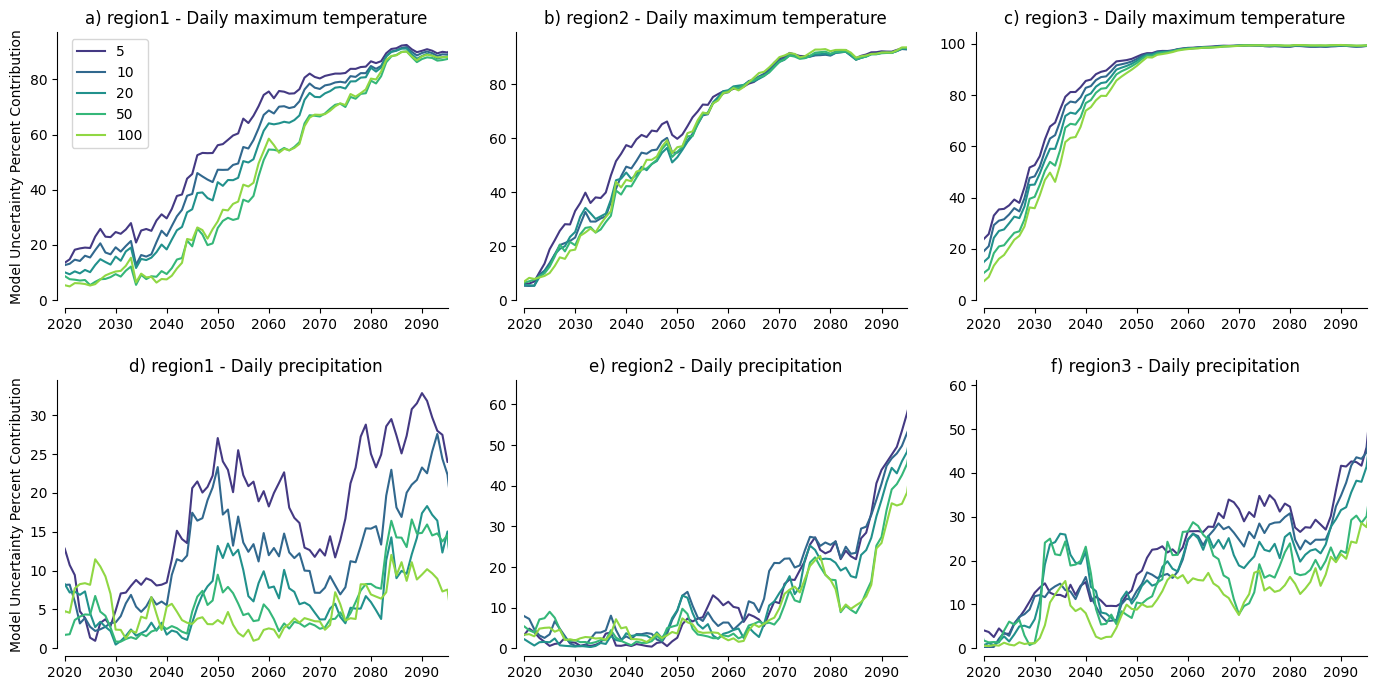

In [91]:
# colors = ['k','b','g','r','orange']
colors = sns.color_palette("viridis", len(test_return.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_return['variable'].values):
    for ir, r in enumerate(test_return.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_return.concat_dim.values):
        # for im, m in enumerate(internal.model.values):
            ax.plot(test_return.sel(variable=v,region=r,concat_dim=m).time,test_return.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['5','10','20','50','100']
axs[0, 0].legend(labels=labels)
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# fig.savefig('./plots/std_uncertainties_noscenario.png', dpi=200)

ValueError: x and y can be no greater than 2D, but have shapes (181,) and (181, 71, 144)

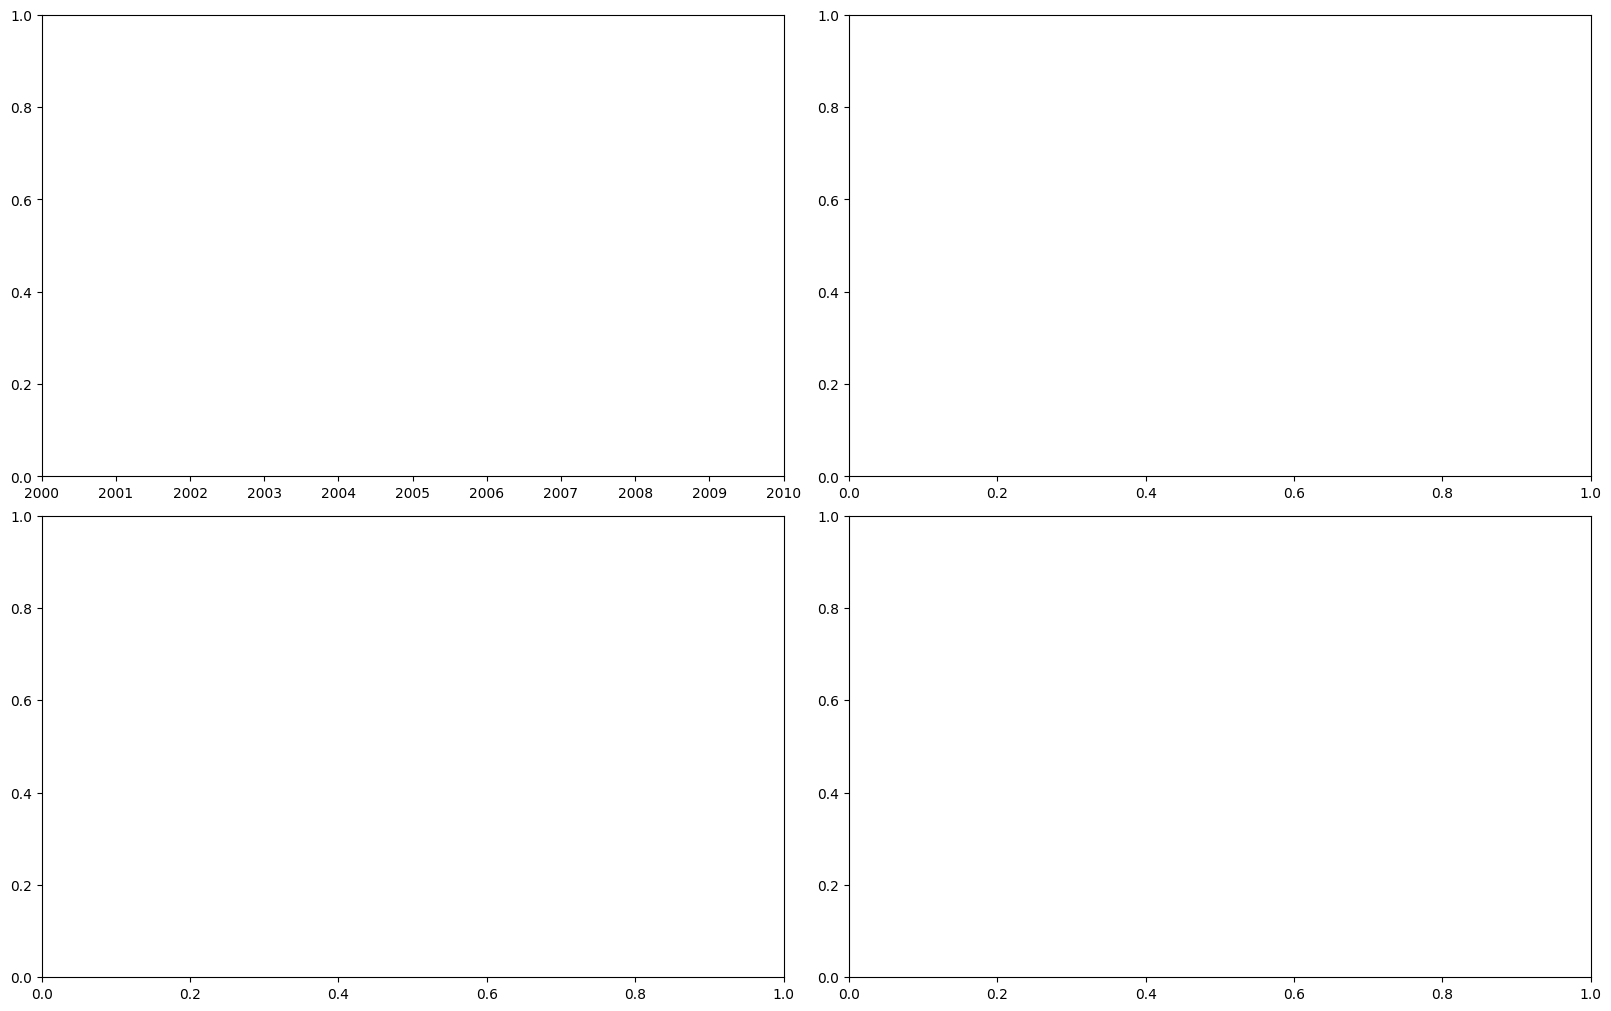

In [40]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("viridis", len(test_return.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_return.concat_dim):
        axe.plot(test_return.sel(region=r,concat_dim=m).time,test_return.sel(region=r,concat_dim=m).MTratio,
                c=colors[i])
        labels=['5','10','20','50','100']
        axe.legend(labels=labels,loc=2,title='Return Period')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,70)

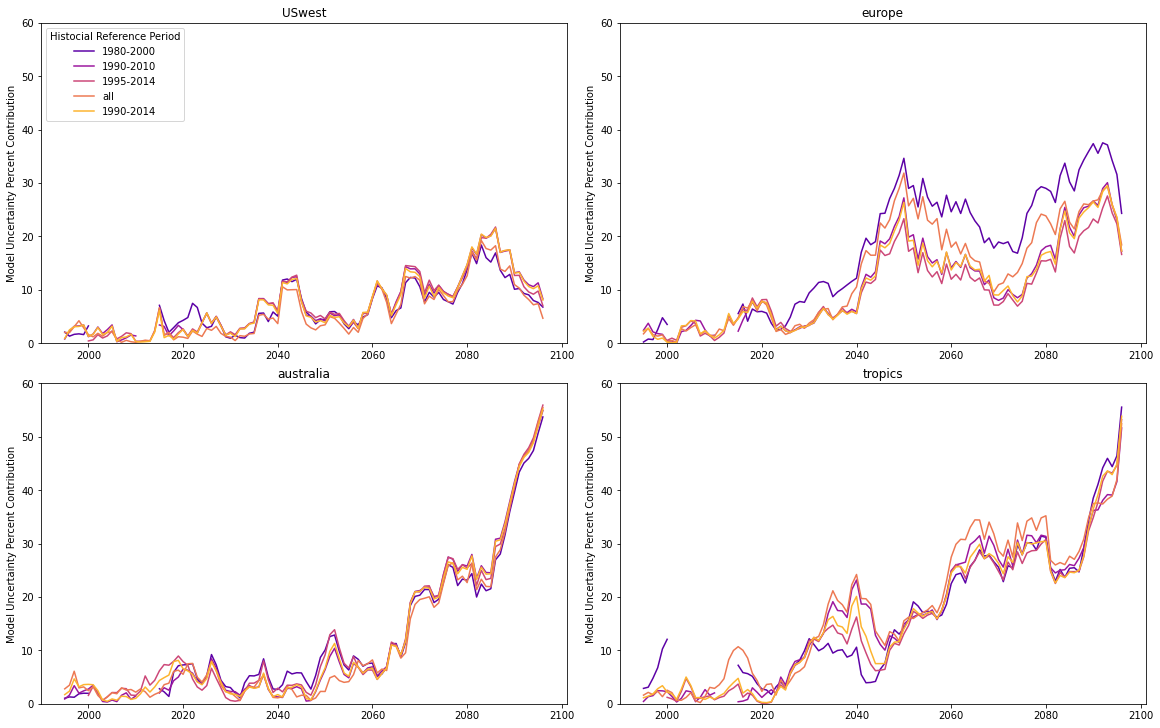

In [44]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("plasma", len(test_histslice.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i in range(len(test_histslice.concat_dim)):
        axe.plot(test_histslice.sel(region=r).isel(concat_dim=i).time,
                 test_histslice.sel(region=r).isel(concat_dim=i).MTratio,
                c=colors[i])
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,60)
labels = ['1980-2000','1990-2010','1995-2014','all','1990-2014']
ax[0,0].legend(labels=labels,loc=2,title='Histocial Reference Period')

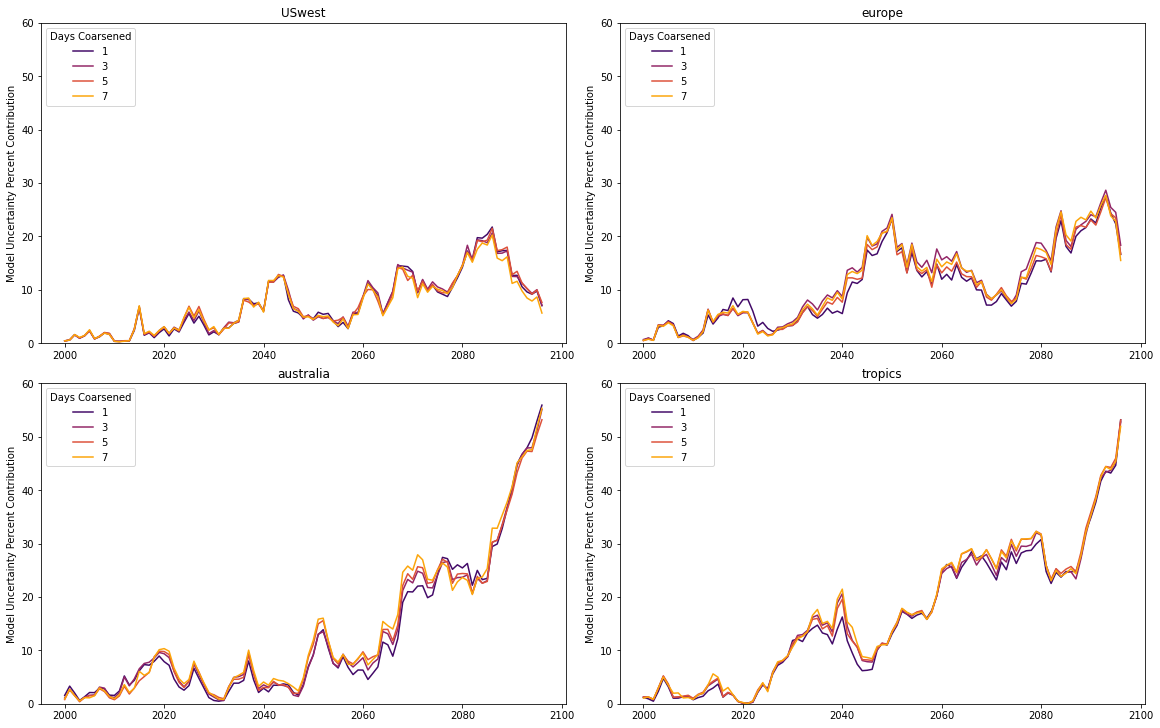

In [46]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_coarsen.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_coarsen.concat_dim):
        axe.plot(test_coarsen.sel(region=r,concat_dim=m).time,test_coarsen.sel(region=r,concat_dim=m).MTratio,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Days Coarsened')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,60)

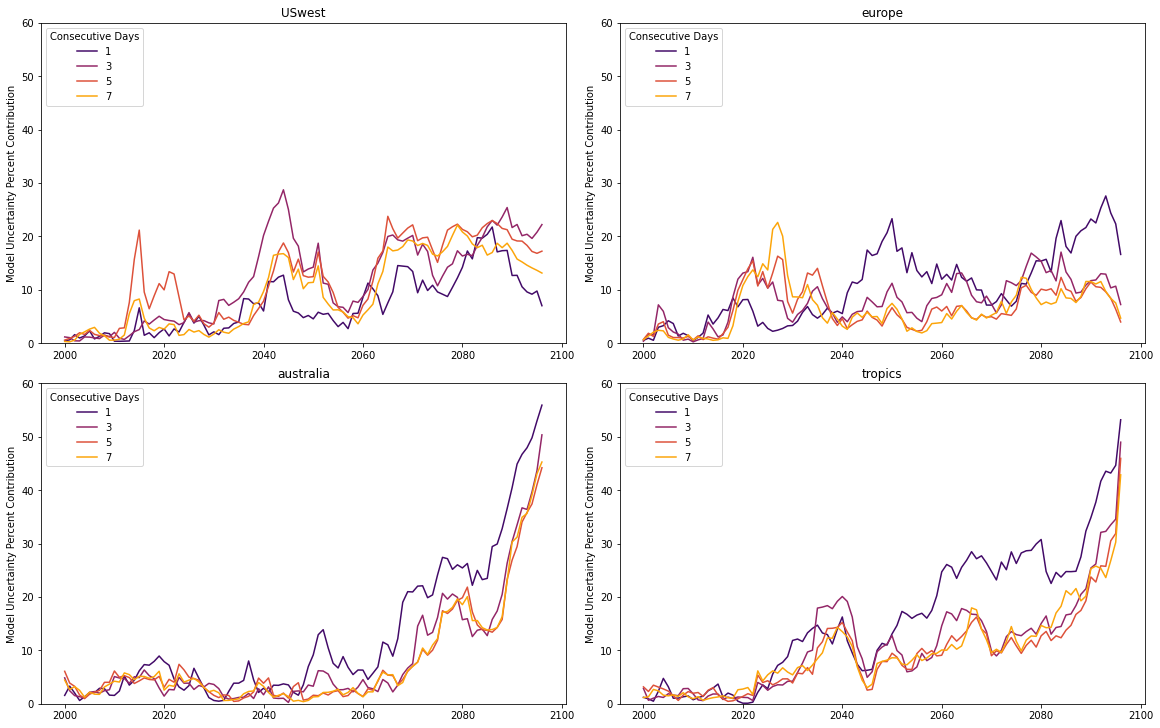

In [49]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_conseq.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_conseq.concat_dim):
        axe.plot(test_conseq.sel(region=r,concat_dim=m).time,test_conseq.sel(region=r,concat_dim=m).MTratio,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Consecutive Days')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,60)

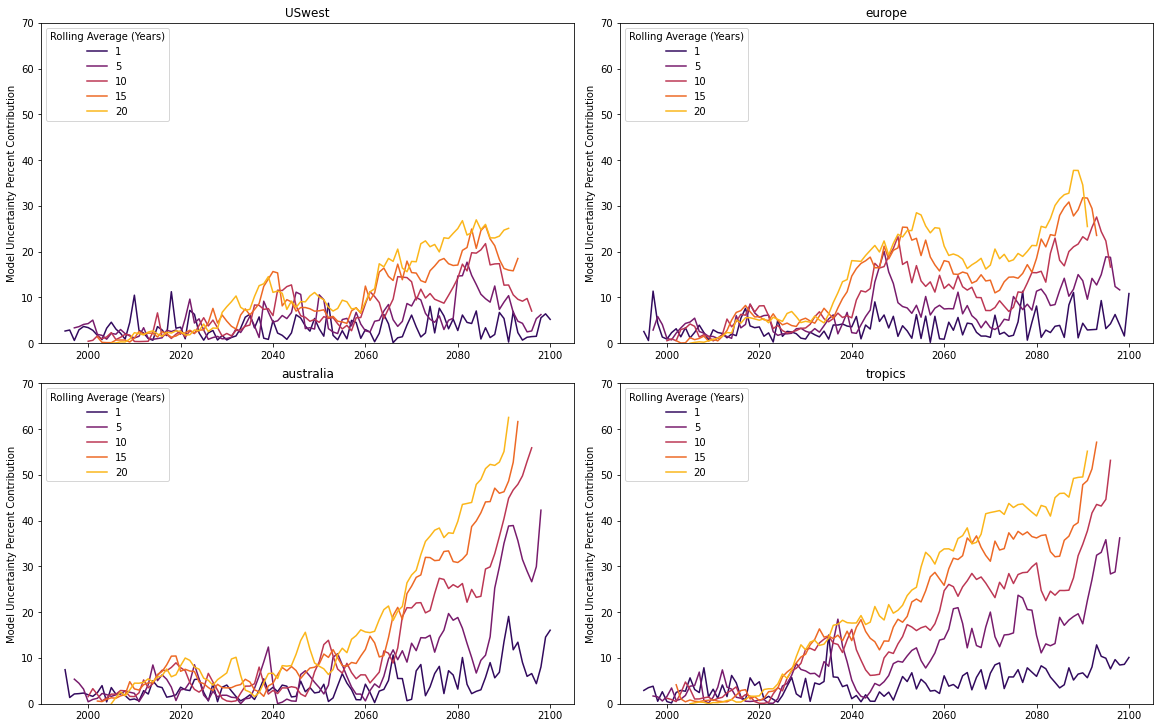

In [53]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_rolling.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_rolling.concat_dim):
        axe.plot(test_rolling.sel(region=r,concat_dim=m).time,test_rolling.sel(region=r,concat_dim=m).MTratio,
                c=colors[i])
        labels=['1','5','10','15','20']
        axe.legend(labels=labels,loc=2,title='Rolling Average (Years)')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,70)

## Load Datasets - Local code 

In [90]:
# settings 
#for temp
# variable = 'tas'
# models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR','EC-Earth3'] 

#for precip - still having issues getting EC-Earth data 
variable = 'pr'
models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR'] 

In [91]:
# USeast = MultiModelLargeEnsemble(models=models,
#                                  variable=variable, granularity='day', lat=41.3, 
#                                  lon=-72.5,bucket='climateai_data_repository', 
#                                  path='tmp/internal_variability',
#                                  load=True)

In [92]:
USwest = MultiModelLargeEnsemble(models=models, scenario='ssp585',
                                 variable=variable, granularity='day', lat=37.7, lon=-122.4,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

In [93]:
# iceland = MultiModelLargeEnsemble(models=models,
#                                  variable=variable, granularity='day', lat=65, lon=-19,
#                                  bucket='climateai_data_repository', 
#                                  path='tmp/internal_variability',
#                                  load=True)

In [94]:
europe = MultiModelLargeEnsemble(models=models,scenario='ssp585',
                                 variable=variable, granularity='day', lat=51,lon=10.5,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

In [95]:
australia = MultiModelLargeEnsemble(models=models, scenario='ssp585',
                                 variable=variable, granularity='day', lat=-25.2,lon=133.7,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

In [96]:
tropics = MultiModelLargeEnsemble(models=models,scenario='ssp585',
                                 variable=variable, granularity='day', lat=3.9,lon=-53.1,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

### sensitivity testing
using model:internal ratio for testing the various parameters. When ratio > 1, model uncertainty dominates. When ratio < 1, internal variability dominates. 

### Return periods 

In [68]:
test_return = sensitivity_allregions(parameter='return_period',
                                     args = {'return_period':[5,10,20, 50, 100],
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':10,
                                                'hist_slice':slice('1995','2014'),
                                             'postprocess':True
                                               })

In [69]:
test_return

<xarray.Dataset>
Dimensions:            (time: 86, member: 58, model: 5, concat_dim: 5, region: 4)
Coordinates:
  * time               (time) datetime64[ns] 2015-01-01 ... 2100-01-01
  * member             (member) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    member_id          (model, member) object 'r16i1p2f1' ... 'r3i1p1f1'
  * model              (model) <U13 'CanESM5' 'cesm_lens' ... 'EC-Earth3'
    quantile           (concat_dim) float64 0.9995 0.9997 0.9999 0.9999 1.0
  * concat_dim         (concat_dim) int64 5 10 20 50 100
  * region             (region) <U9 'USwest' 'europe' 'australia' 'tropics'
Data variables: (12/17)
    tas_occurance      (region, concat_dim, model, member, time) float64 nan ...
    model_le           (region, concat_dim, time) float64 nan nan ... nan nan
    internal_mean_le   (region, concat_dim, time) float64 nan nan ... nan nan
    internal_var_le    (region, concat_dim, time) float64 nan nan ... nan nan
    total_le           (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_le    (region, concat_dim, time) float64 nan nan ... nan nan
    ...                 ...
    model_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    total_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    internal_fit_frac  (region, concat_dim, time) float64 nan nan ... nan nan
    model_fit_frac     (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_fit   (region, concat_dim, time) float64 nan nan ... nan nan
    MTratio            (region, concat_dim, time) float64 nan nan ... nan nan

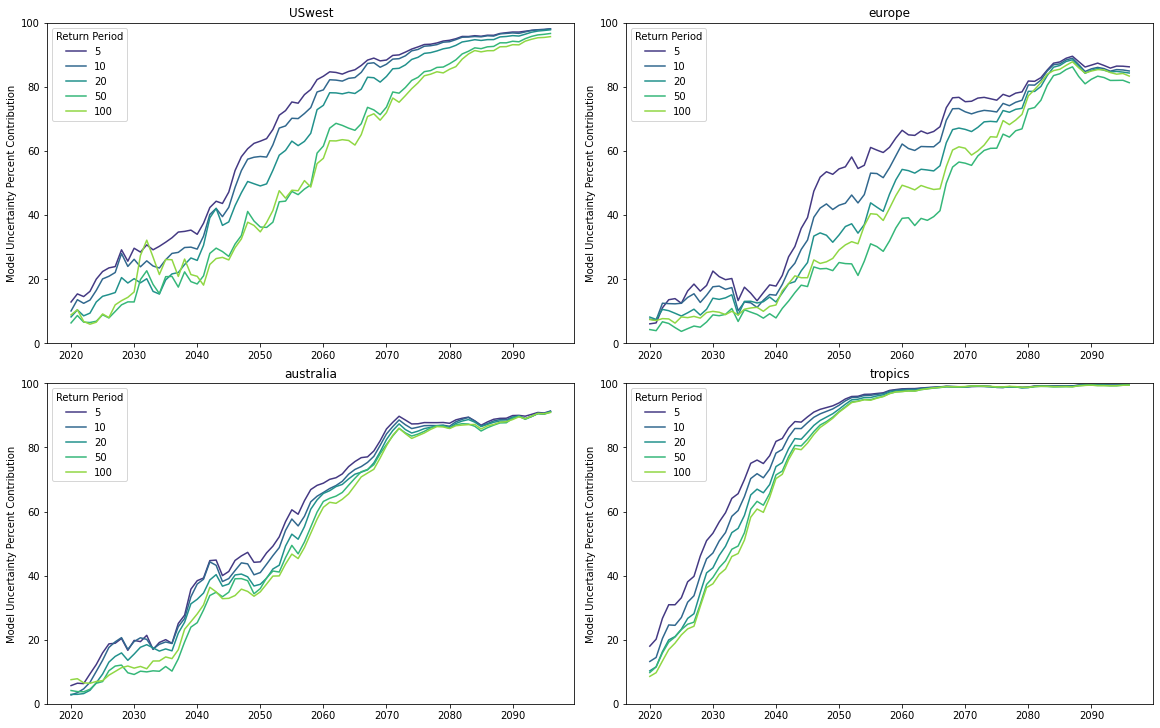

In [71]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("viridis", len(test_return.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_return.concat_dim):
        axe.plot(test_return.sel(region=r,concat_dim=m).time,test_return.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['5','10','20','50','100']
        axe.legend(labels=labels,loc=2,title='Return Period')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)
        

For temp: greater internal variability for larger return periods. US west and Europe have largest spreads. Convergence towards the end of the century for all return periods when model uncertainty dominates. This point is reached much earlier for the tropics. 

### Hist_slice

In [34]:
test_histslice = sensitivity_allregions(parameter='hist_slice',
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':10,
                                                'hist_slice':[slice('1920','1940'),slice('1960','1980'),
                                                              slice('1990','2010'),slice('1995','2014'),
                                                              slice(None, None), slice('1990', None)],
                                               'postprocess':False}
                                       )

In [35]:
test_histslice

<xarray.Dataset>
Dimensions:            (time: 86, member: 50, model: 4, concat_dim: 6, region: 4)
Coordinates:
  * time               (time) datetime64[ns] 2015-01-01 ... 2100-01-01
  * member             (member) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    member_id          (model, member) object 'r16i1p2f1' 'r16i1p1f1' ... nan
  * model              (model) <U13 'CanESM5' 'cesm_lens' ... 'MPI-ESM1-2-LR'
    quantile           (concat_dim) float64 0.9997 0.9997 ... 0.9997 0.9997
  * concat_dim         (concat_dim) object slice('1920', '1940', None) ... sl...
  * region             (region) <U9 'USwest' 'europe' 'australia' 'tropics'
Data variables: (12/17)
    pr_occurance       (region, concat_dim, model, member, time) float64 nan ...
    model_le           (region, concat_dim, time) float64 nan nan ... nan nan
    internal_mean_le   (region, concat_dim, time) float64 nan nan ... nan nan
    internal_var_le    (region, concat_dim, time) float64 nan nan ... nan nan
    total_le           (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_le    (region, concat_dim, time) float64 nan nan ... nan nan
    ...                 ...
    model_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    total_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    internal_fit_frac  (region, concat_dim, time) float64 nan nan ... nan nan
    model_fit_frac     (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_fit   (region, concat_dim, time) float64 nan nan ... nan nan
    MTratio            (region, concat_dim, time) float64 nan nan ... nan nan

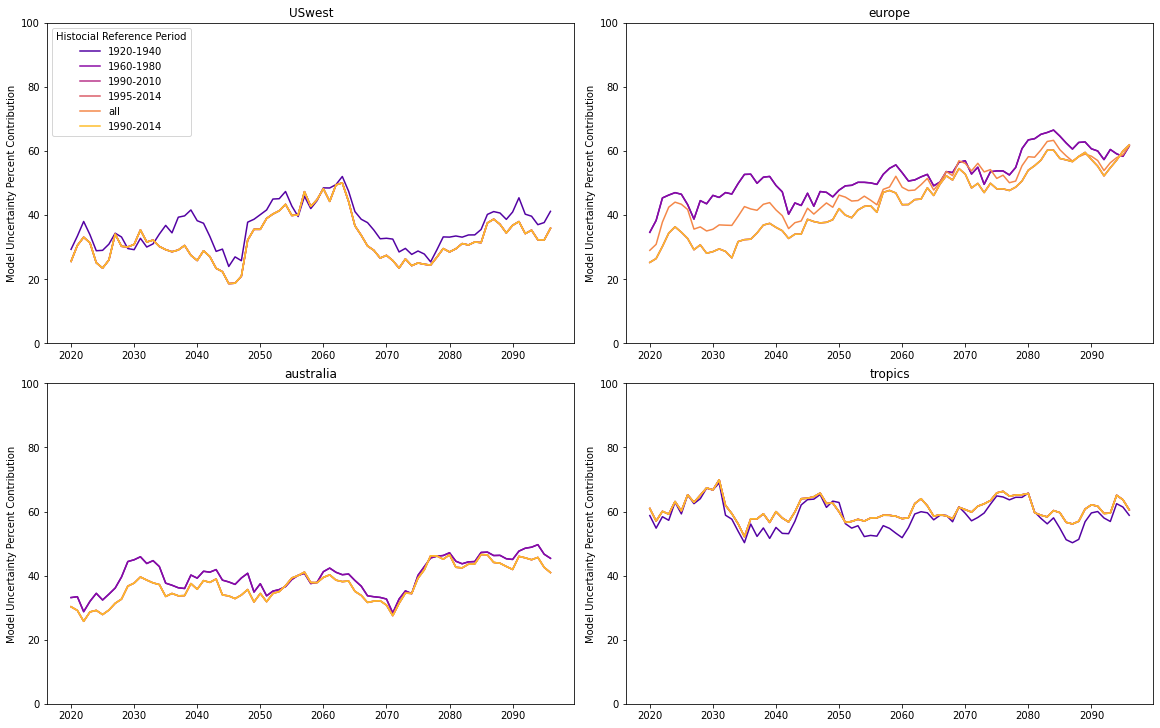

In [56]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("plasma", len(test_histslice.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i in range(len(test_histslice.concat_dim)):
        axe.plot(test_histslice.sel(region=r).isel(concat_dim=i).time,test_histslice.sel(region=r).isel(concat_dim=i).model_le_frac,
                c=colors[i])
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
labels = ['1920-1940','1960-1980','1990-2010','1995-2014','all','1990-2014']
ax[0,0].legend(labels=labels,loc=2,title='Histocial Reference Period')

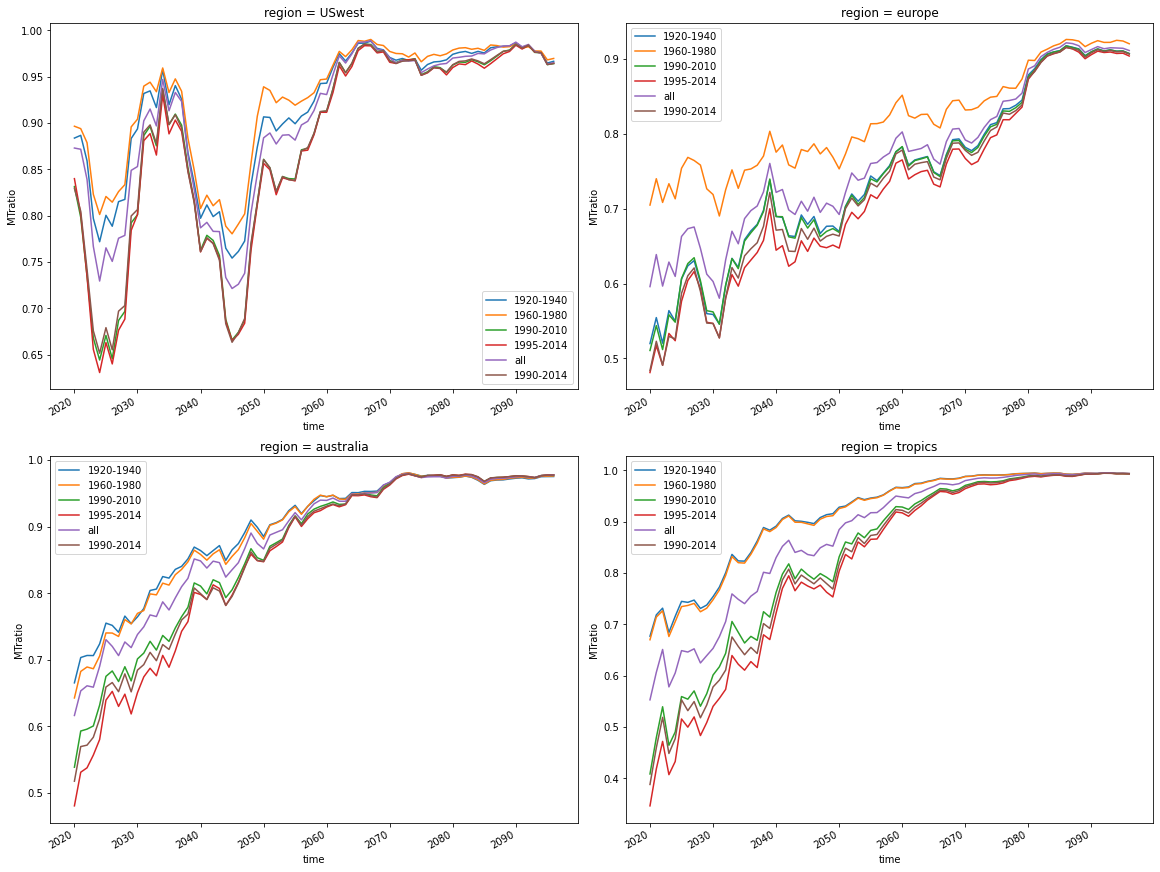

In [34]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_histslice.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe,add_legend=False);
    labels = ['1920-1940','1960-1980','1990-2010','1995-2014','all','1990-2014']
    axe.legend(labels)

### coarsen

In [72]:
test_coarsen = sensitivity_allregions(parameter='coarsen',
                                    args = {'return_period':10,
                                            'coarsen':[1,3,5,7],
                                            'conseq_days':1,
                                            'rolling_average':10,
                                            'hist_slice':slice('1995','2014'),
                                            'postprocess':True
                                           })

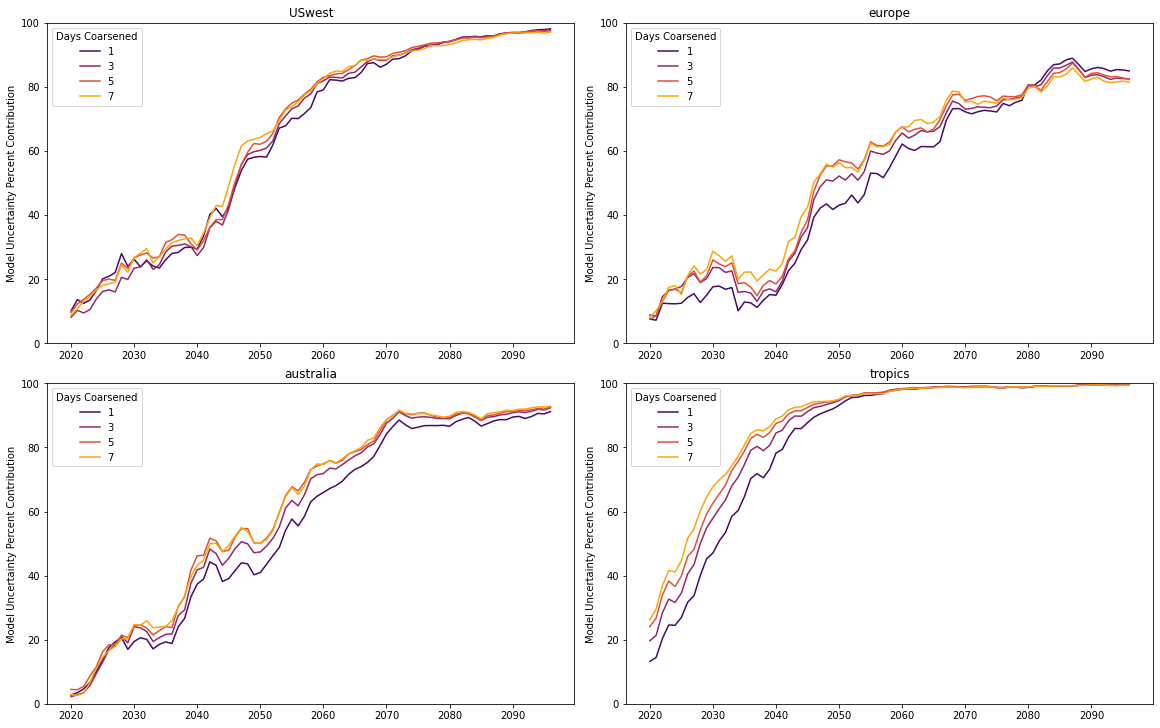

In [74]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_coarsen.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_coarsen.concat_dim):
        axe.plot(test_coarsen.sel(region=r,concat_dim=m).time,test_coarsen.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Days Coarsened')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)
        

### Consecutive days 

In [84]:
test_conseq = sensitivity_allregions(parameter='conseq_days',
                       args= {'return_period':10,
                              'coarsen':1,
                              'conseq_days':[1,3,5,7],
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014'),
                              'postprocess':True
                             }
                      )

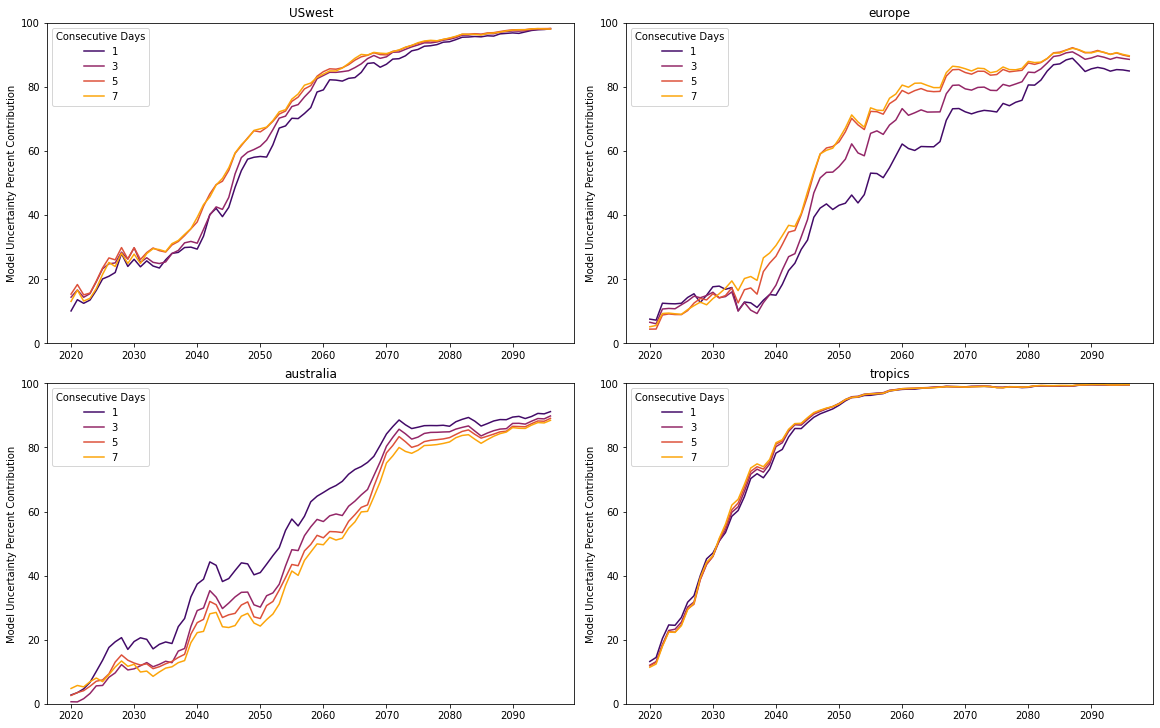

In [77]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_conseq.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_conseq.concat_dim):
        axe.plot(test_conseq.sel(region=r,concat_dim=m).time,test_conseq.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Consecutive Days')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)

#### coarsen / consec combo

In [97]:
test_conseq = extreme_internal_allregions(
                       args= {'return_period':10,
                              'coarsen':3,
                              'conseq_days':7,
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014'),
                              'postprocess':True
                             }
                      )

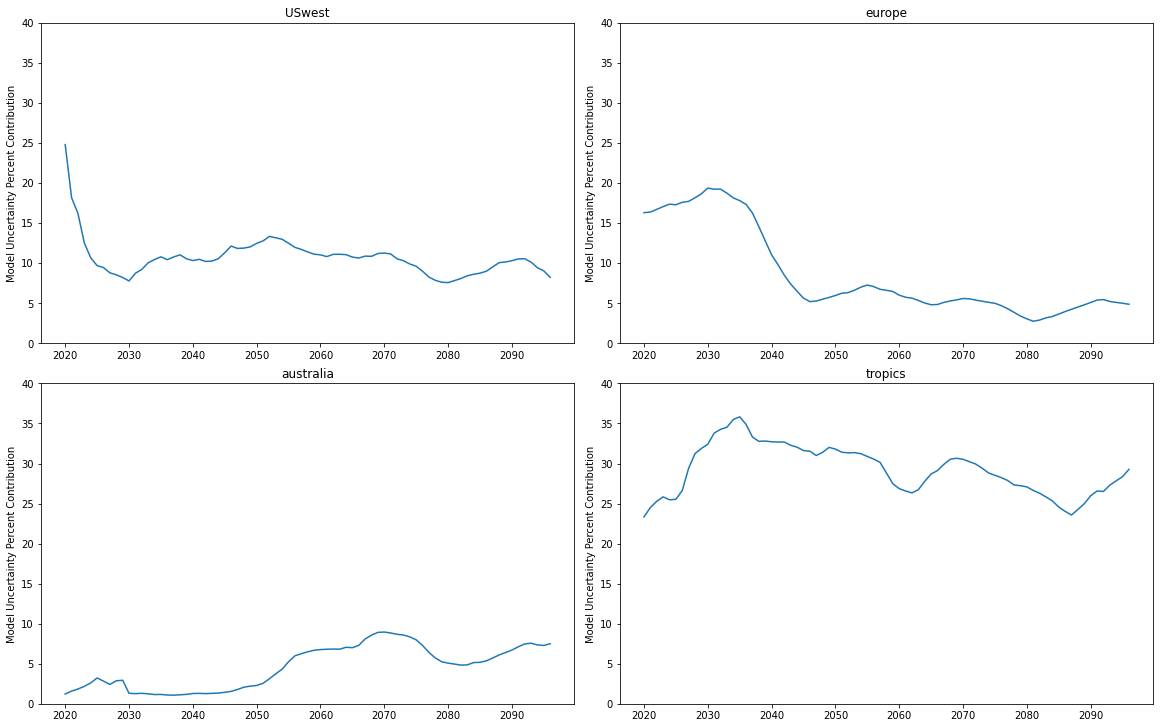

In [99]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
# colors = sns.color_palette("inferno", len(test_conseq.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    axe.plot(test_conseq.sel(region=r).time,test_conseq.sel(region=r).model_le_frac)
        # axe.legend(labels=labels,loc=2,title='Consecutive Days')
    axe.set_ylabel('Model Uncertainty Percent Contribution')
    axe.set_title(r)
    axe.set_ylim(0,40)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)

### rolling average

In [78]:
test_rolling = sensitivity_allregions(parameter='rolling_average',
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':[1,5,10,15,20],
                                                'hist_slice':slice('1995','2014'),
                                                'postprocess':True
                                               }
                                     )

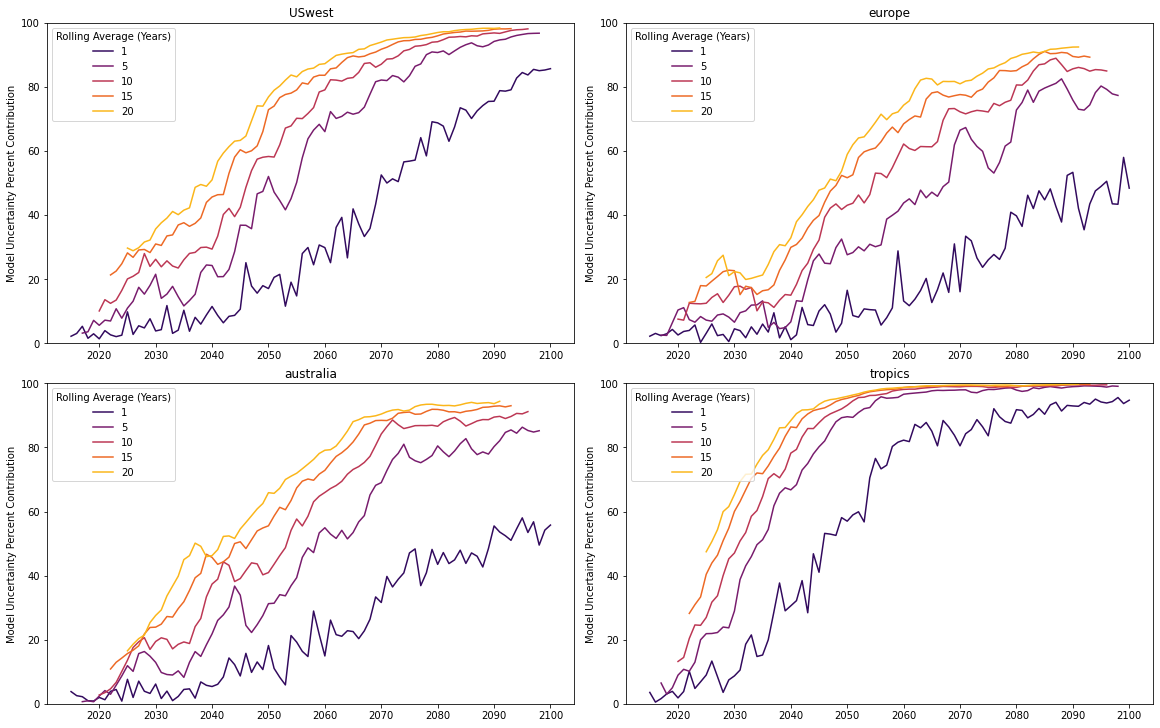

In [80]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_rolling.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_rolling.concat_dim):
        axe.plot(test_rolling.sel(region=r,concat_dim=m).time,test_rolling.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['1','5','10','15','20']
        axe.legend(labels=labels,loc=2,title='Rolling Average (Years)')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)